# **Visualizing Relationship Between Binding and Perturbation Response**

This tutorial walks you through the methods and approaches taken to process the data and visualize trends within the data in regard to the binding and perturbation effects of TFs on genes in preparation for model training.

In [52]:
#imports 

import pandas as pd
import numpy as np
from scipy.stats import rankdata, pearsonr
import asyncio
import nest_asyncio
import seaborn as sns
import matplotlib.pyplot as plt
from yeastdnnexplorer.interface import *
nest_asyncio.apply()
from typing import List, Optional
import warnings
from patsy import dmatrices, dmatrix, demo_data

## **Accessing combined TF data**

The cell below displays the first 3 TFs that contain aggregated Calling Cards binding data in the database. You can modify the command to return the entire list of TFs that contain aggregated data if needed. This code is mostly taken from the database_interface tutorial, refer to it if needed for more information on how to use the database. 

In [240]:
pss_api = PromoterSetSigAPI()

pss_api.push_params({"datasource": "brent_nf_cc", "aggregated": "true"})

callingcards_aggregated_meta_res = await pss_api.read()

callingcards_aggregated_meta_df = callingcards_aggregated_meta_res.get("metadata")

# Prints the first 3 TFs that have aggregated data available. Modify as necessary to see the whole list of TFs
print(callingcards_aggregated_meta_df["regulator_symbol"][:3])

# Prints the total number of TFs that have aggregated data available.
print("Total number of TFs with aggregated data: "+ str(len(callingcards_aggregated_meta_df["regulator_symbol"])))

0    WTM1
1    MIG2
2    CAT8
Name: regulator_symbol, dtype: object
Total number of TFs with aggregated data: 71


#### Code
Given the length of the methods below, it is optimal to hide the cells after running them to ensure readability of the notebook. 

This method asynchronously retrieves and processes data for a given transcription factor. It combines the desired binding and perturbation data for the chosen TF and returns a DataFrame containing both the binding and perturbation data which we will use for further analysis.

In [33]:
#TODO: add a test for this method for future integration into the source code

async def process_transcription_factor_async(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_source: str, pseudocount: int = 1) -> pd.DataFrame:    
    """
    Process transcription factor data by retrieving and merging binding and perturbation datasets.

    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param is_aggregated: Indicates whether the data is aggregated.
    :type is_aggregated: bool
    :param binding_source: The source of the binding data, e.g., "cc" or "harbison".
    :type binding_source: str
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional

    :returns: A DataFrame containing the combined and processed binding and perturbation data.
    :rtype: pd.DataFrame
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for binding data
    pss_api_tf = PromoterSetSigAPI()

    # Access the relevant data depending on the binding source and aggregation status
    if binding_source == "cc":
        if is_aggregated:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
        else:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    elif binding_source == "harbison":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "4"})
    elif binding_source == "mitra":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "2"})
    elif binding_source == "chip_exo":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "3"})

    # Asynchronously read the binding data from the API
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    # Get the ID of the retrieved binding data
    id = tf_pss.get("metadata")["id"][0]
    # Extract the binding data using the ID
    binding_df = tf_pss.get("data").get(str(id))

    # Initialize API for perturbation data
    expression = ExpressionAPI()

    # Map perturbation source to corresponding source number
    source_mapping = {
        "mcisaac": "7",
        "hu_reimann": "5",
        "kemmeren": "6"
    }
    source_number = source_mapping.get(perturbation_source, "unknown")
    
    # Push parameters to retrieve the perturbation data
    if perturbation_source == "mcisaac":
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number, "time": "15"})
    else:
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number})

    # Asynchronously read the perturbation data from the API
    expression_res = await expression.read(retrieve_files=True)
    # Get the ID of the retrieved perturbation data
    id = expression_res.get("metadata")["id"][0]
    # Extract the perturbation data using the ID
    expression_df = expression_res.get("data").get(str(id))

    # Read perturbation data
    perturbation_data = expression_df
    # Read binding data
    binding_data = binding_df

    # Rename columns in binding data for consistency and clarity
    if binding_source == "cc":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "harbison":
        binding_data.rename(columns={"pval": "pvalue"}, inplace=True)
    elif binding_source == "mitra":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "chip_exo":
        binding_data.rename(columns={"max_fc": "effect", "min_pval": "pvalue"}, inplace=True)

    # Optional: here you can modify the pseudocount as needed. The default pseudocount is set to 1.
    # Calculate the effect size for binding data using the provided formula
    if binding_source == "cc":
        binding_data['effect'] = (binding_data['experiment_hops'] / binding_data['experiment_total_hops']) / \
                             ((binding_data['background_hops'] + pseudocount) / binding_data['background_total_hops'])

    # Merge the binding data and perturbation data on the 'target_locus_tag' column
    combined_data = pd.merge(binding_data, perturbation_data, on='target_locus_tag', suffixes=('_binding', '_perturbation'))

    # # Assert that the length of combined_data is the minimum of the lengths of binding_data and perturbation_data
    # assert len(combined_data) <= min(len(binding_data), len(perturbation_data)), \
    #     f"Length of combined_data ({len(combined_data)}) is not equal to the minimum of lengths of binding_data ({len(binding_data)}) and perturbation_data ({len(perturbation_data)})"

    # Keep only the necessary columns in the combined data
    combined_data = combined_data[['target_locus_tag', 'effect_binding', 'effect_perturbation', 'pvalue_binding']]

    # Reorder the combined data by the smallest 'pvalue_binding' values
    combined_data = combined_data.sort_values(by='pvalue_binding')

    # Apply transformations:
    # - Take the absolute value of 'effect_perturbation'
    # - Calculate the negative log10 of 'pvalue_binding'
    # - Calculate the log10 of 'effect_binding'
    combined_data['effect_perturbation'] = combined_data['effect_perturbation'].abs()
    combined_data['neg_log_pvalue_binding'] = -np.log10(combined_data['pvalue_binding'])
    combined_data['log_enrichment'] = np.log10(combined_data['effect_binding'])

    # Return the processed combined data as a DataFrame
    return combined_data

The process_transcription_factor method below is used to call the asynchronous process_transcription_factor_async function above in a way that works with regular, step-by-step code. We need this function to use the method above in loops or other structures that don’t handle asynchronous functions well.

In [34]:
def process_transcription_factor(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_data: str, pseudocount: int = 1) -> pd.DataFrame:
    """
    Processes transcription factor data synchronously by invoking an asynchronous function.
    
    This function runs the asynchronous `process_transcription_factor_async` function synchronously to handle 
    transcription factor data processing. It retrieves the event loop, runs the asynchronous function, 
    and returns the processed DataFrame.
    
    :param tf_name: The name of the transcription factor.
    :type tf_name: str
    :param is_aggregated: A boolean flag indicating whether the data is aggregated.
    :type is_aggregated: bool
    :param perturbation_source: The source of the perturbation data.
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional
    
    :returns: A DataFrame containing the processed transcription factor data.
    :rtype: pd.DataFrame
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        loop = asyncio.get_event_loop()
        return loop.run_until_complete(process_transcription_factor_async(tf_name, is_aggregated, binding_source, perturbation_data, pseudocount))

#### Application

Here is an applied example of using the methods above to obtain the combined data for the transcription factor AFT1 from the Calling Cards binding data and the hu_reimann perturbation data.

In [8]:
process_transcription_factor("AFT1", False, "cc", "hu_reimann")

,target_locus_tag,effect_binding,effect_perturbation,pvalue_binding,neg_log_pvalue_binding,log_enrichment
4773,YEL065W,40.645338,0.307065,0.000000,inf,1.609011
4772,YEL067C,31.354975,0.309224,0.000000,inf,1.496306
1033,YLR136C,90.116521,0.395634,0.000000,inf,1.954804
3828,YCL018W,167.226533,0.055596,0.000000,inf,2.223305
2657,YOR203W,92.903630,0.179912,0.000000,inf,1.968033
...,...,...,...,...,...,...
5685,YGR240C,0.000000,0.070498,0.992207,0.003398,-inf
2542,YOR092W,0.000000,0.041109,0.994933,0.002206,-inf
941,YLR044C,0.000000,0.044537,0.995450,0.001980,-inf
3554,YBR082C,0.130850,0.185228,0.995484,0.001966,-0.883226


## **Applying Transformations to the Data**

Since various TFs will have different distributions of enrichment scores and poisson pvalues, it is helpful to use a ranking of these values as opposed to the magnitudes themselves to make for easier comparisons across multiple TFs. Since there are thousands of data points in each TF, using a log will shrink the scale of these ranks, allowing us to focus better on the trends in the data. We are specifically interested in how the poisson pvalue associated with TF binding relates to the actual perturbation effect. 

#### Code

Thus, we take the negative log ranks of these two columns to determine if there is a relationship across all TFs. Taking the negative log of the rank means that the highest ranked data will be the least negative. Since we assign higher ranks to smaller poisson pvalues and larger perturbation effects, we would hope to see a positive linear trend when graphing this data as more significant binding interactions should ideally correlate with larger perturbations. The process_dataframe method below does this to enable more meaningful analysis.

In [35]:
def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes a DataFrame further by calculating ranks and log transformations for expression and binding data to elucidate certain trends.
    
    :param df: The input DataFrame containing 'effect_perturbation' and 'pvalue_binding' columns.
    :type df: pd.DataFrame
    
    :returns: A DataFrame that includes the original data along with new columns for expression ranks, log-transformed ranks, 
              binding ranks, and is sorted by the negative log-transformed binding rank.
    :rtype: pd.DataFrame
    """
    # Calculate expression rank with average ties method
    df['expression_rank'] = rankdata(-abs(df['effect_perturbation']), method='average')

    # Log transform the expression rank
    df['neg_expression_rank_log'] = -np.log10(df['expression_rank'])

    # Calculate binding rank with average ties method
    df['binding_rank'] = rankdata(df['pvalue_binding'], method='average')

    # Calculate log transform of the binding rank
    df['neg_log_rank_binding'] = -np.log10(df['binding_rank'])

    # Select specific columns
    plotting_df = df[['target_locus_tag','effect_perturbation', 'expression_rank', 'neg_expression_rank_log', 
                      'pvalue_binding', 'binding_rank', 'neg_log_rank_binding']]

    # Arrange (sort) by neg_log_rank_binding in descending order
    plotting_df = plotting_df.sort_values(by='neg_log_rank_binding', ascending=False)
    
    return plotting_df

## **Visualizing the Transformed Data Using Bins**

The create_bins method is designed to create "bins" of data for a specified column in the input DataFrame. Binning data is a method of grouping continuous values into discrete intervals or "bins." This process can help in reducing variance and revealing general trends in a dataset, which is needed in this instance to better see the trend between the log rank binding (LRB) and log rank perturbation response (LRR) across various TFs.

#### Code

This method gives you the option of adjusting the size of each bin, or selecting the number of bins you want to create. For example, choosing bin_size = None and num_bins = 5 will create 5 bins of equal size based on the range of LRB values, but note that the number of data points in each bin may vary as the data is not uniformly distributed.

In [36]:
def create_bins(data: pd.DataFrame, column: str, bin_size: Optional[float] = None, num_bins: Optional[int] = None) -> pd.Series:
    """
    Creates bins for a specified column in a DataFrame.
    
    :param data: A DataFrame containing the data to be binned.
    :type data: pd.DataFrame
    :param column: The name of the column to be binned.
    :type column: str
    :param bin_size: The size of each bin (optional, default is None). If specified, the range of the data will be partitioned into bins of this size.
    :type bin_size: Optional[float]
    :param num_bins: The number of bins (optional, default is None). If specified, the range of the data will be partitioned into this number of bins.
    :type num_bins: Optional[int]
    
    :returns: A set of bins that partitions the data along the desired column value.
    :rtype: pd.Series
    """
    if bin_size is not None:
        bin_edges = np.arange(data[column].min(), data[column].max() + bin_size, bin_size)
    elif num_bins is not None:
        bin_edges = np.linspace(data[column].min(), data[column].max(), num_bins + 1)
    else:
        raise ValueError("Either bin_size or num_bins must be specified")
    return pd.cut(data[column], bins=bin_edges, include_lowest=True, right=False)

The plot_with_custom_bins method creates a scatter plot to visualize the effects of this binning process on the data.

In [11]:
def plot_with_custom_bins(data: pd.DataFrame, bin_size: Optional[float] = None, num_bins: Optional[int] = None) -> None:
    """
    Bins the 'neg_log_rank_binding' column using the specified bin size or number of bins, calculates the mean of 'neg_expression_rank_log' for each bin, and plots these means against the bin centers. It also fits a LOESS line on the binned data and displays the number of data points in each bin.
    
    :param data: The input DataFrame containing 'neg_log_rank_binding' and 'neg_expression_rank_log' columns.
    :type data: pd.DataFrame
    :param bin_size: The size of each bin (optional, default is None). If specified, the range of the data will be partitioned into bins of this size.
    :type bin_size: Optional[float]
    :param num_bins: The number of bins (optional, default is None). If specified, the range of the data will be partitioned into this number of bins.
    :type num_bins: Optional[int]
    
    :returns: None
    :rtype: None
    """

    # Suppress specific runtime warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Create bins for the 'neg_log_rank_binding' column using the specified bin size or number of bins
        data['bin'] = create_bins(data, 'neg_log_rank_binding', bin_size, num_bins)
        
        # Calculate the mean of 'neg_expression_rank_log' for each bin
        binned_means = data.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
        
        # Calculate the center of each bin for the 'neg_log_rank_binding' column
        bin_centers = data.groupby('bin', observed=True)['neg_log_rank_binding'].mean().reset_index()
        
        # Count the number of data points in each bin and sort the counts by bin order
        bin_counts = data['bin'].value_counts().sort_index().reset_index(drop=True)

        # Plotting the data
        plt.figure(figsize=(10, 6))  # Set the figure size
        # Create a scatter plot of bin centers vs. binned means
        plt.scatter(bin_centers['neg_log_rank_binding'], binned_means['neg_expression_rank_log'], color='blue', label='Binned Means')
        
        # Add the number of data points for each bin as text labels on the plot
        for i in range(len(bin_centers)):
            plt.text(bin_centers['neg_log_rank_binding'][i], binned_means['neg_expression_rank_log'][i] - 0.007, str(bin_counts[i]), 
                     color='black', ha='left', va='top', fontsize=9)
        
        # Set the labels and title for the plot
        plt.xlabel('Negative Log10 Rank Binding')  # Label for the x-axis
        plt.ylabel('Negative Log10 Expression Rank')  # Label for the y-axis
        plt.title('Negative Log Rank Binding vs Negative Log Expression Rank on Binned Data')  # Title of the plot
        plt.legend()
        plt.show()

#### Application

Now that we have covered the main methods, here is an example of them in action. In this case, we are interested in displaying the binning for the single transcription factor "AFT1." We are using a pseudocount of 10.3922 to calculate the enrichment scores and p values. Then we bin the data using 5 bins and graph the scatterplot.

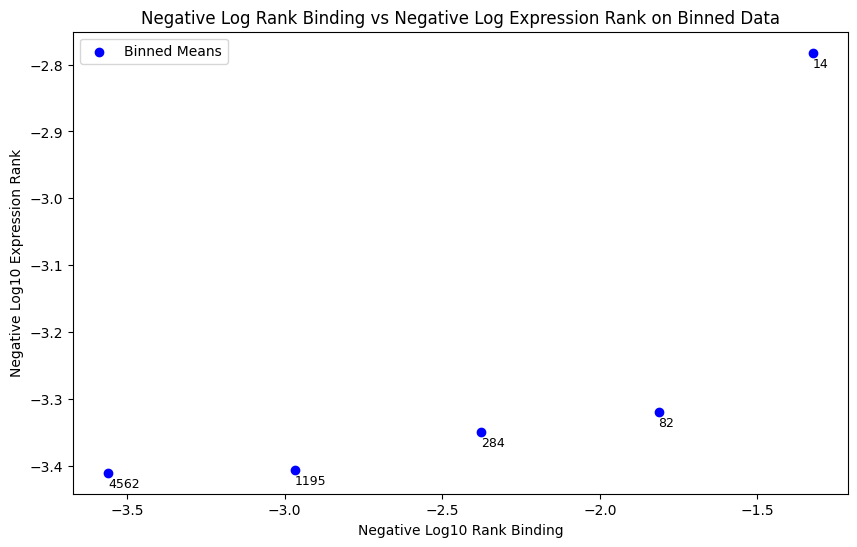

In [12]:
combined_data = process_transcription_factor("AFT1", False, "cc", "mcisaac", 10.3922)
plotting_df = process_dataframe(combined_data)
plot_with_custom_bins(plotting_df, num_bins=5)

The x-axis of this plot is the negative log of the binding poisson pvalue ranks. Recall that ties are handled by taking an average across data points with the same value to assign ranks. Data with smaller pvalue magnitudes are presumed to be more significant, therefore they occupy the highest ranks (i.e. 1, 2, 3, etc.). When taking the negative log of these ranks, points that are closer to 0 constitute points with these higher ranks, and points are that more negative correspond to lower ranked and therefore larger pvalues for binding. 

The y-axis of this plot is the negative log of the perturbation effect ranks. A similar line of logic with regard to the rankings applies here as it does with the x-axis. However, in this instance, data with larger perturbation effects are more important, and therefore they occupy the higher ranks. Thus, data that is closer to 0 corresponds to higher perturbation effects, and those that are more negative correspond to perturbation effects that are ranked lower and tend to have smaller magnitude of effect.

Also, it is important to notice that the number of datapoints in each of the bins here is not the same. There appear to be significantly more points that occupy the leftmost bin. This means that there are likely many ties among points that have larger binding pvalues, therefore there is a greater concentration of these points in the leftmost bin in contrast to the bins on the right. By the same virtue, there is a significantly smaller quantity of points in the rightmost bin, indicating less ties among points that have smaller binding pvalues.

The general trend of these binned means shows a postive, upward response. This finding aligns with our hypothesis that more significant binding effects (which are measured here using the poisson pvalue of binding) should correlate with points that have more significant perturbation effects (measured here using the magnitude of the perturbation effect). However, we want the trend to be consistent across all TFs, as we seek to identify a general relationship that the eventual model can learn from in hopes of enhancing its predictive power.

#### Code

The process_and_plot_tfs method processes and plots data for a list of transcription factors (TFs). For each TF, it retrieves and processes the data, and then creates a plot using custom bins. This method serves as a comprehensive pipeline to handle multiple TFs, from data retrieval and processing to visualization.

In [98]:
def process_and_plot_tfs(tf_list: List[str], boolean_list: List[bool], binding_source: str, perturbation_source: str, bins: Optional[int] = 5, pseudocount: Optional[int] = 1) -> None:
    """
    Processes and plots data for a list of transcription factors (TFs). This function iterates over each TF in the list, accounting for 
    whether or not they possess aggregate data, then processes this data and generates plots with the specified number of bins for each.
    
    :param tf_list: A list of transcription factor names.
    :type tf_list: List[str]
    :param boolean_list: A list of boolean values indicating whether the data is aggregated for each transcription factor.
    :type boolean_list: List[bool]
    :param perturbation_source: The source of the perturbation data.
    :type perturbation_source: str
    :param bins: The number of bins for plotting (optional, default is 5).
    :type bins: Optional[int]
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: Optional[int]
    
    :returns: None
    :rtype: None
    """
    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        # Iterate over each transcription factor in the list
        for i in range(len(tf_list)):
            print(f"Processing and plotting for TF: {tf_list[i]}")
        
            # Access the transcription factor data
            combined_data = process_transcription_factor(tf_list[i], boolean_list[i], binding_source, perturbation_source, pseudocount)
        
            # Process the combined data to calculate ranks and transformations
            plotting_df = process_dataframe(combined_data)
        
            # Plot the processed data with custom bins
            plot_with_custom_bins(plotting_df, num_bins=bins)

#### Application

Below is an example of a list of 4 more TFs we want to visualize this trend for, which we can do by utilizing this method

Processing and plotting for TF: MIG2


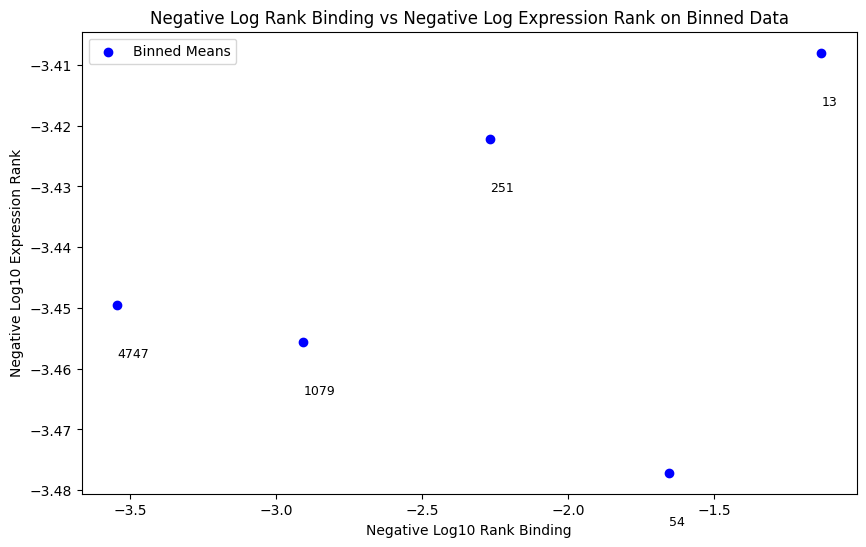

Processing and plotting for TF: CAT8


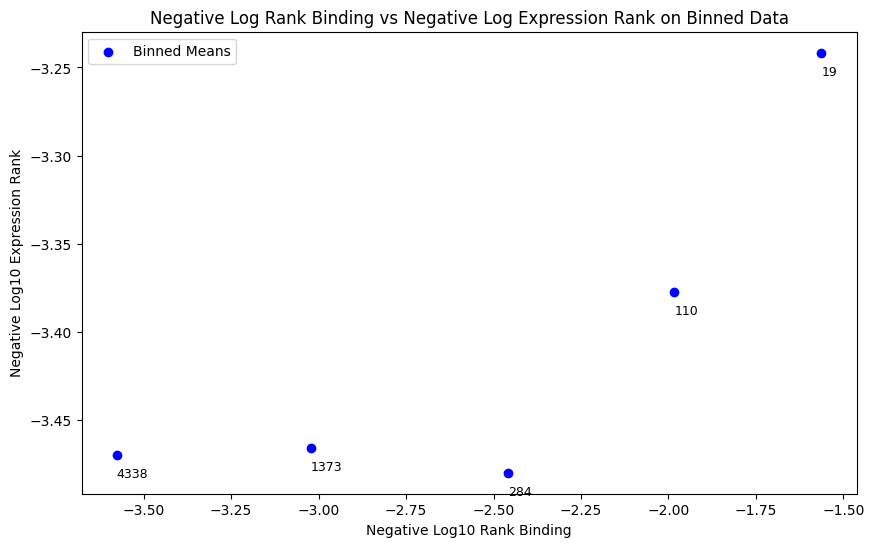

Processing and plotting for TF: PDR1


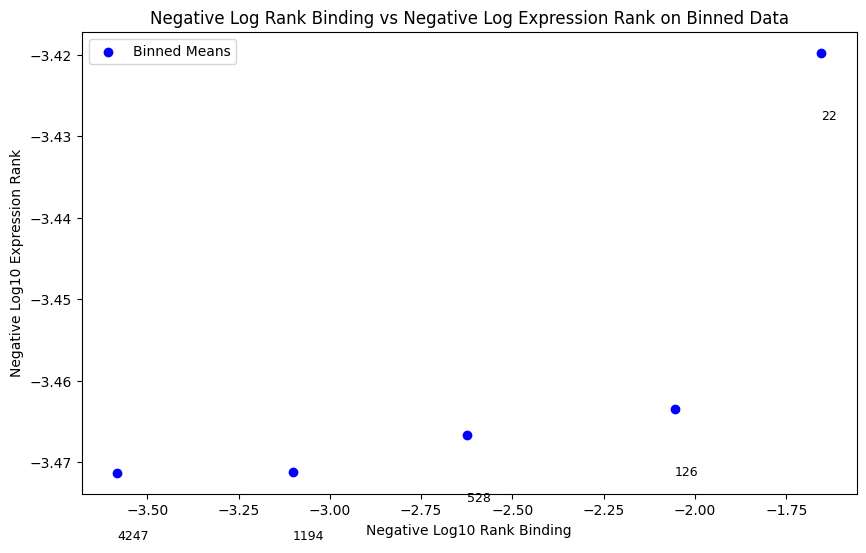

Processing and plotting for TF: PHO4


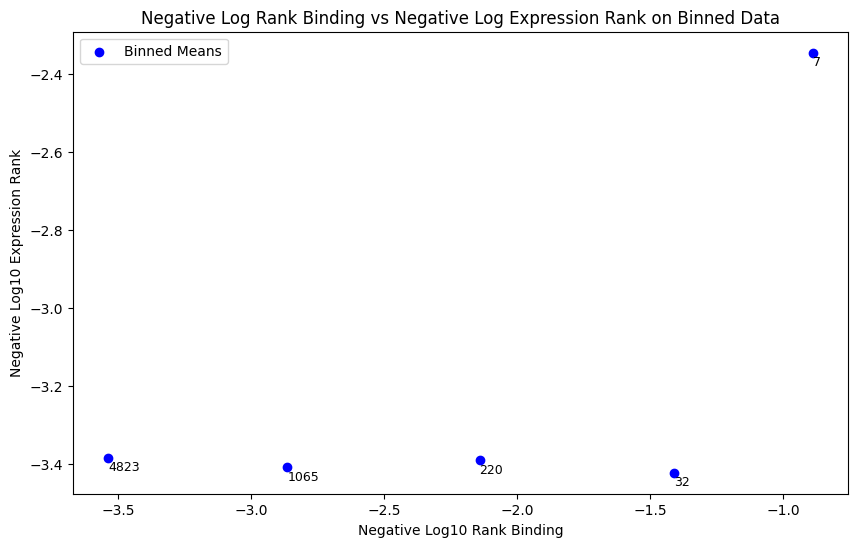

In [11]:
tfs = ['MIG2', 'CAT8', 'PDR1', 'PHO4']
boolean_list = [True] * 4
process_and_plot_tfs(tfs, boolean_list, "cc", "mcisaac")

While the latter 3 plots tend to exhibit the same upward trend as the plot above, the first plot for the TF MIG2 looks more unusual. The second point from the right on this plot representing the binned mean data for that range of negative log rank binding pvalues has a mean negative log expression rank that is significantly lower than expected. This means that for the data points within that bin, which is second only to the bin containing the points with the smallest binding pvalues, has on average the lowest ranked perturbation effects out of all of the bins. However, it is also important here to recognize the scale of the y-axis. Neither the positive nor negative trends we have observed exhibit a large change. Even through the graphs can look quite significant, it is important to recognize that the scale of the y-axis is actually quite small.

For further exploration of this trend across more TFs, below is example of code that will plot the trend for 71 TFs including the 5 shown above. You can continue exploring how this trend persists across TFs.

In [118]:
#tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3','FHL1', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'FZF1', 'HAP2', 'HAP3', 'HAP5','INO4', 'ERT1', 'TOG1', 'MET4', 'PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RSF2', 'RME1', 'HIR2', 'SIP4', 'GCR1', 'HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1','XBP1', 'ZNF1', 'YHP1', 'RDR1', 'PDR3', 'RLM1', 'SFL1', 'SMP1', 'SUT2', 'HAC1', 'PHD1', 'ARO80']
#len(tfs)
#boolean_list = [True] * 59 + [False] * 12
#process_and_plot_tfs(tfs, boolean_list, "cc", "mcisaac")

## **Further Visualization Techniques on the Data**

### **Boxplots of Adjacent Binned Mean Differences**

As we have seen above, even after transforming the data and applying this method of binning, the general trend that we expect to see isn't present in every transcription factor. While looking at the graph of each TF can be helpful, it would be important to investigate how this trend holds up in general across all of the TFs in our database, especially as that number becomes quite large and manual inspection of each TF is not optimal.

#### Code

The following method adjacent_differences_box_plot will create four boxplots on the same plot based on the binning process used above. For our exploratory data analysis, we settled on using 5 bins as the initial graphs for all TFs exhibited the best trends when usin this number of bins. Thus, for each TF, the method will calculate the difference between two adjacent bin means, doing this four times total for the five binned means. For each of the four values, the data across all TFs is aggregated, and a boxplot is made for each of these four datasets to visualize the trend in across all TFs.

In [13]:
def adjacent_differences_store_data(tfs: List[str], boolean_list: List[bool], binding_source: List[str], perturbation_sources: List[str], bins: int, pseudocount: Optional[int] = 1) -> dict:
    """
    Stores the differences between adjacent bins for a list of transcription factors.
    
    This function processes transcription factor data, calculates differences between the means of adjacent bins,
    and stores these differences across multiple transcription factors.
    
    :param tfs: A list of transcription factors that you want to plot.
    :type tfs: List[str]
    :param boolean_list: A list of boolean values indicating whether the data is aggregated for each transcription factor.
    :type boolean_list: List[bool]
    :param perturbation_sources: A list of sources of the perturbation data.
    :type perturbation_sources: List[str]
    :param bins: The number of bins to create.
    :type bins: int
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: Optional[int]
    
    :returns: A dictionary containing the stored data for each perturbation source.
    :rtype: dict
    """
    # Initialize a dictionary to store differences between adjacent bins for each perturbation source
    diff_data = {source: [[] for _ in range(bins - 1)] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            for source in perturbation_sources:
                # Process the transcription factor data
                combined_data = process_transcription_factor(str(tfs[i]), boolean_list[i], binding_source[i], source, pseudocount)
                
                # Further process the combined data to calculate ranks and transformations
                plotting_df = process_dataframe(combined_data)
                
                # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
                plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
                
                # Calculate the mean of 'neg_expression_rank_log' for each bin
                binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
                
                # Initialize a list to store the differences between adjacent bins
                binned_mean_diffs = []
                
                # Calculate the differences between the means of adjacent bins
                for j in range(bins - 1):
                    binned_mean_diffs.append(binned_means["neg_expression_rank_log"][j+1] - binned_means["neg_expression_rank_log"][j])
                
                # Append the differences to the corresponding list in diff_data
                for j in range(bins - 1):
                    diff_data[source][j].append(binned_mean_diffs[j])

    # Remove NaN values from all bin difference lists
    for source in diff_data:
        diff_data[source] = [[x for x in bin_diff if not pd.isnull(x)] for bin_diff in diff_data[source]]

    return diff_data

In [14]:
def compare_adjacent_stored_data_box_plots(stored_data_list: List[dict], labels: List[str]) -> None:
    """
    Generates a box plot comparing multiple sets of stored data and adds a horizontal line at y=0.
    
    :param stored_data_list: A list of dictionaries containing stored data for each perturbation source.
    :type stored_data_list: List[dict]
    :param labels: A list of labels corresponding to each set of stored data.
    :type labels: List[str]
    
    :returns: None
    :rtype: None
    """
    plt.figure(figsize=(20, 13))
    boxplot_data = []
    source_labels = []
    bin_labels = []

    for j in range(4):
        for idx, stored_data in enumerate(stored_data_list):
            for source, data in stored_data.items():
                boxplot_data.append(data[j])
                source_labels.append(labels[idx])
                bin_labels.append(f'Bins {j+1} and {j+2}')

    box_positions = list(range(1, len(boxplot_data) + 1))

    plt.boxplot(boxplot_data, positions=box_positions, widths=0.6)
    plt.axhline(y=0, color='gray', linestyle='--')  

    # Set the primary x-axis labels (perturbation sources)
    plt.xticks(ticks=box_positions, labels=source_labels, rotation=90, ha='center')

    # Add bin labels below the primary x-axis
    ax = plt.gca()
    ax2 = ax.secondary_xaxis('bottom')
    unique_bins = list(set(bin_labels))
    bin_label_positions = []
    for unique_bin in unique_bins:
        positions = [box_positions[i] for i, bin_label in enumerate(bin_labels) if bin_label == unique_bin]
        center_position = sum(positions) / len(positions)
        bin_label_positions.append(center_position)
    ax2.set_xticks(bin_label_positions)
    ax2.set_xticklabels(unique_bins, rotation=0, ha='center', weight='bold', fontsize=12)
    
    # Adjust the position of the primary x-axis labels and the secondary x-axis labels
    plt.subplots_adjust(bottom=0.3)  # Adjust bottom to make space for source labels
    ax.tick_params(axis='x', which='major', pad=25)  # Increase the padding for the source labels

    plt.xlabel('Perturbation Sources and Bins')  
    plt.ylabel('Difference in Binned LRR Means')  
    plt.title('Comparison of Adjacent Binned LRR Mean Differences Between Perturbation Sources')

    plt.show()

#### Application

Here, we use this method to plot the boxplots for the above TF data. Note that we are augmenting the Calling Cards binding data with data from the mitra lab. You can see the breakdown of which TFs come from which set by referencing the index of the all_tfs list with the cc_to_mitra_ratio_in_all list.

In [15]:
all_tfs = ['WTM1','MIG2','RIM101','GZF3','ASH1','GAT3','TEC1','SIP3','SKN7','WTM2','HAA1','MET31','CRZ1','CHA4','ZAP1','SKO1','ACA1','FZF1','HAP2','HAP3','HAP5','INO4','ERT1','PPR1','RTG1','MOT3','CBF1','MSN2','DAL80','RTG3','GAL80','RSF2','RME1','HIR2','SIP4','HAP4','UME1','USV1','MGA1','CIN5','ROX1','XBP1','RDR1','PDR3','RLM1','SFL1','SMP1','SUT2','PHD1','SUT1','SOK2','STP2','YRR1','GAL4','LEU3','OAF1','SWI6','ACE2','TYE7','RGM1','GCN4','MIG3','STB5','RFX1','ARG80','ARG81','CST6','AZF1','SFP1','GTS1','FKH1','YOX1','FKH2','DIG1','MET28','RGT1','GCR2']
boolean_list = [True]*41 + [False]*37
cc_to_mitra_ratio_in_all = ["cc"]*49+["mitra"]*29

In [17]:
cc_mcisaac_adjacent_boxplot_data = adjacent_differences_store_data(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, ["mcisaac"]*78, 5)

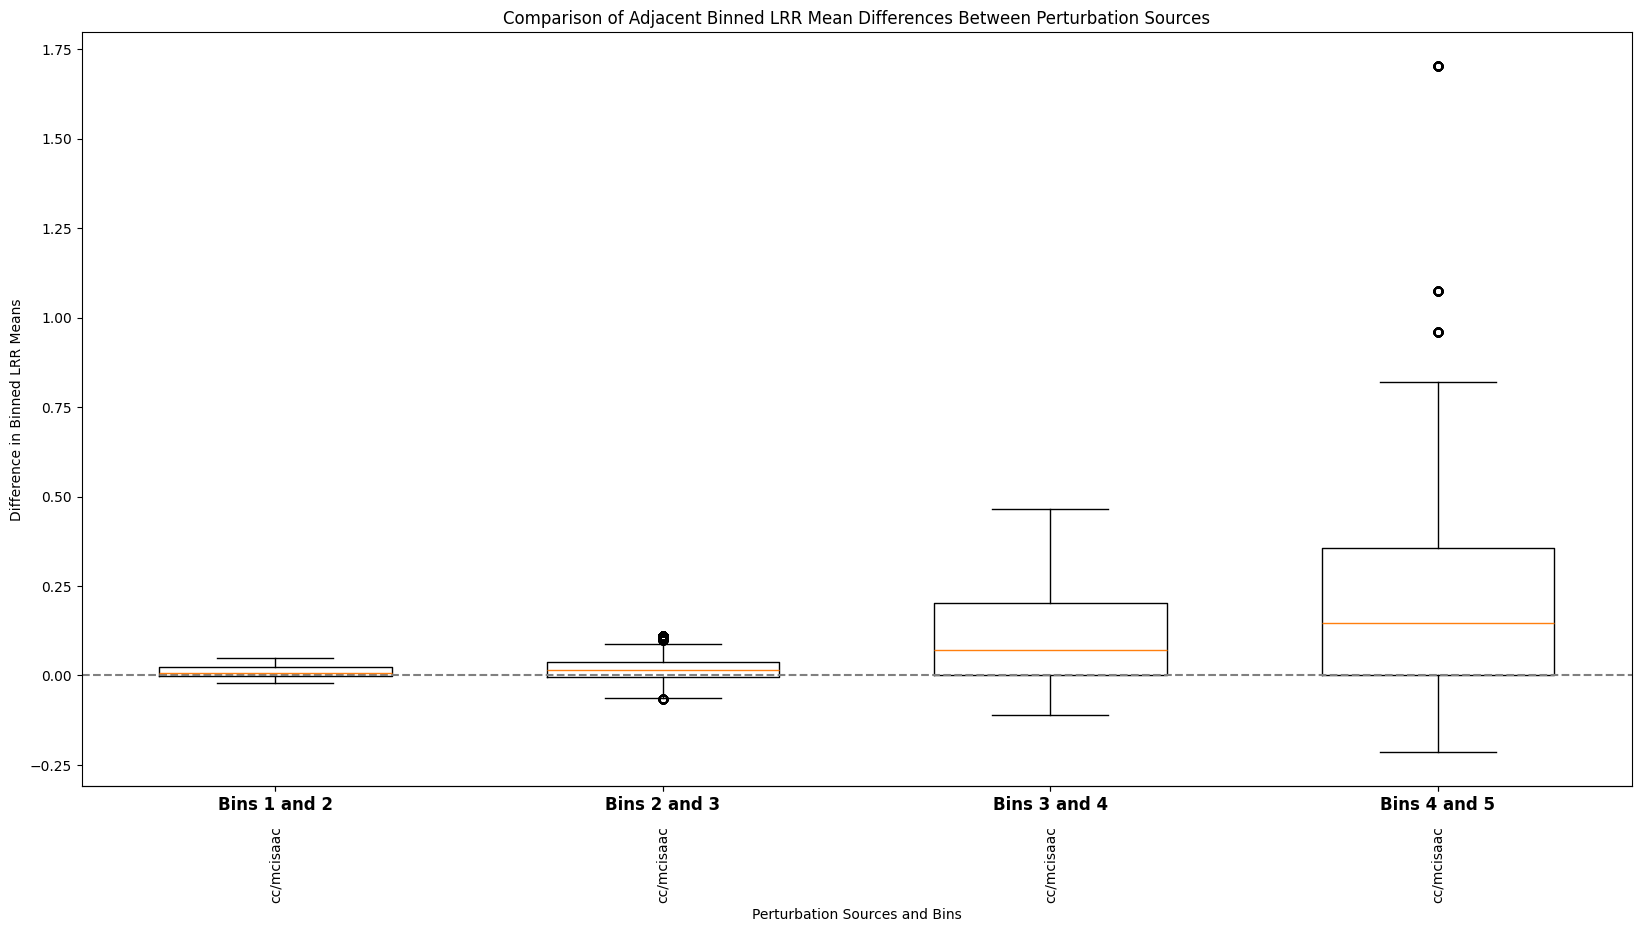

In [18]:
compare_adjacent_stored_data_box_plots([cc_mcisaac_adjacent_boxplot_data], ["cc/mcisaac"])

This boxplot illustrates the differences in the binned mean LRR values (as shown on the y-axis) between adjacent bins (on the x-axis) across 71 transcription factors. For instance, "Bins 1 and 2" shows the difference in expression ranks between the first and second bins, "Bins 2 and 3" between the second and third bins, and so on. In the first boxplot, representing "Bins 1 and 2," the interquartile range (IQR) is very narrow, and the median difference is around zero, indicating little change in expression ranks between these bins for most TFs. 

As we move to "Bins 2 and 3," a similar trend is observed, with the median still close to zero and a narrow spread of the data near 0, suggesting minimal differences in expression ranks between these bins. However, as we progress to "Bins 3 and 4" and "Bins 4 and 5," we see an increasing spread in the data. The median differences for these bins are also higher, especially in "Bins 4 and 5," where the median is significantly above zero. This indicates that for many TFs, there is a noticeable change in expression ranks in the later bins, with the differences becoming more pronounced. The highest quartile in "Bins 4 and 5" indicates that the binned mean LRR changes considerably for some TFs, with the top of the boxplot extending to around 0.8, corresponding to a factor of 10^0.8 or approximately 6.3. This means that the expression rank could change by this factor from one bin to the next, demonstrating a significant shift. The presence of outliers further indicates that there are some TFs with even more substantial changes between these bins. 

Overall, this boxplot reveals that the differences between adjacent bins become more pronounced as we move to higher bins. This trend signifies that the expression ranks of TFs change more significantly in the later bins, highlighting a general pattern of increasing variability in the data as we move from earlier to later bins. So, while for some individual TFs the trend may not be evident (like the example shown above) it seems that across the entire dataset, this trend is generally consistent and can serve as a decent relationship that our models can use to learn from the data and result in more accurate predictions.

### **Boxplots of Binned Mean Differences Between the First and Last Bins**

For a broader look at how the binned means differ, this is an additional method that takes the difference in the binned mean values between the first and last bin for each TF only. Then the data across all TFs is aggregated, and a boxplot is made to visualize the overall difference across all TFs. We can use this to determine further if there truly is a significant increase in the binned means across the first and last bins. Additionally, these boxplots are much simpler to look at for a given binding/perturbation data set compared to the 4 boxplots shown on the adjacent bin differences plot above. Thus, we can compare how these single boxplots differ across all binding and perturbation datasets by plotting them in an array that makes it easy to visualize comparisons.

#### Code

The following method first_last_bin_difference_box_plot_comparisons will save the data needed to create boxplots of the first and last bin mean differences, which can then be plotted on the same plot to enable comparison between binding/perturbation dataset combinations. For each TF, the method will calculate the difference between the first and last bin means. For each of the four values, the data across all TFs is aggregated.

In [22]:
def first_last_bin_difference_box_plot_comparisons(tfs: List[str], boolean_list: List[bool], binding_source: List[str], perturbation_sources: List[str], bins: int, pseudocount: Optional[int] = 1) -> dict:
    """
    Generates a box plot of the differences between the first and last bins for a list of transcription factors.
    
    This function processes transcription factor data, calculates differences between the means of the first and last bins,
    and generates a box plot to visualize these differences across multiple transcription factors.
    
    :param tfs: A list of transcription factors that you want to plot.
    :type tfs: List[str]
    :param boolean_list: A list of boolean values indicating whether the data is aggregated for each transcription factor.
    :type boolean_list: List[bool]
    :param perturbation_sources: A list of sources of the perturbation data.
    :type perturbation_sources: List[str]
    :param bins: The number of bins to create.
    :type bins: int
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: Optional[int]
    
    :returns: A dictionary containing the stored data for each perturbation source.
    :rtype: dict
    """
    # Initialize a dictionary to store differences between the first and last bins for each perturbation source
    diff_data = {source: [] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            for source in perturbation_sources:
                #print(str(i+1) +": "+tfs[i])
                # Process the transcription factor data
                combined_data = process_transcription_factor(str(tfs[i]), boolean_list[i], binding_source[i], source, pseudocount)
                
                # Further process the combined data to calculate ranks and transformations
                plotting_df = process_dataframe(combined_data)
                
                # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
                plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins = bins)
                
                # Calculate the mean of 'neg_expression_rank_log' for each bin
                binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
                
                # Calculate the difference between the first and last bin means
                first_last_diff = binned_means["neg_expression_rank_log"].iloc[-1] - binned_means["neg_expression_rank_log"].iloc[0]
                
                # Append the difference to the corresponding list in diff_data
                diff_data[source].append(first_last_diff)

    # Remove NaN values from all bin difference lists
    for source in diff_data:
        diff_data[source] = [x for x in diff_data[source] if not pd.isnull(x)]

    return diff_data

The compare_first_and_last_stored_data_box_plots method below plots all of the boxplots on the same plot to enable easy comparison. It takes in data generated by the method directly above and uses the data to plot all of the boxplots. Note that you need to supply labels and make sure they correspond to the correct dataset. 

In [23]:
def plot_boxplots(data: List[List[float]], binding_labels: List[str], perturbation_labels: List[str], data_type: str) -> None:
    """
    Plots an array of boxplots with specified binding and perturbation labels.

    :param data: A list of lists containing numerical data for each boxplot.
    :type data: List[List[float]]
    :param binding_labels: A list containing the labels for the binding data ("cc" and "harbison").
    :type binding_labels: List[str]
    :param perturbation_labels: A list containing the labels for the perturbation data ("mcisaac", "kemmeren", "hu_reimann").
    :type perturbation_labels: List[str]

    :returns: None
    :rtype: None
    """
    # Flatten the data to find the global min and max
    all_data = np.concatenate(data)
    
    # Calculate global min and max, rounding to the nearest 0.5
    global_min = np.floor(np.min(all_data) * 2) / 2  # Round down to nearest 0.5
    global_max = np.ceil(np.max(all_data) * 2) / 2   # Round up to nearest 0.5

    # Determine number of rows and columns
    num_datasets = len(data)
    if num_datasets == 1:
        nrows, ncols = 1, 1
    else:
        ncols = 3
        nrows = (num_datasets + ncols - 1) // ncols  # Calculate the required number of rows

    # Create subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axs = np.array(axs).reshape(-1)  # Flatten the 2D array of axes to iterate over them easily

    for i, ax in enumerate(axs):
        if i < num_datasets:
            ax.boxplot(data[i])
            row = i // ncols
            col = i % ncols
            if col == 0 and len(binding_labels) > row:
                ax.set_ylabel(binding_labels[row])
            if row == nrows - 1 and len(perturbation_labels) > col:
                ax.set_xlabel(perturbation_labels[col])
            ax.axhline(y=0, color='red', linestyle='--')  # Add dashed line at y=0
            
            # Set y-axis limits based on global min and max
            ax.set_ylim(global_min, global_max)
        else:
            ax.axis('off')  # Turn off any unused subplot axes
    if data_type == "diffs":
        fig.suptitle(f'Boxplot of Differences in Means Between First and Last Bins Across {len(data[0])} TFs')  
    elif data_type == "correlations":
        fig.suptitle(f'Boxplot of Pearson Correlations Between LRR/LRB Across {len(data[0])} TFs')  
    plt.tight_layout()
    plt.show()

#### Application

We will first plot the boxplot for a single dataset that uses the CC+mitra binding data as well as the mcisaac perturbation data.

In [50]:
all_tfs = ['WTM1','MIG2','RIM101','GZF3','ASH1','TEC1','SIP3','SKN7','WTM2','HAA1','MET31','CRZ1','CHA4','ZAP1','SKO1','FZF1','HAP2','HAP3','HAP5','INO4','RTG1','MOT3','CBF1','MSN2','RTG3','RSF2','HIR2','SIP4','UME1','CIN5','ROX1','XBP1','RDR1','PDR3','RLM1','SFL1','SMP1','PHD1','SUT1','SOK2','STP2','AFT2','YRR1','GAL4','LEU3','SWI6','ACE2','RGM1','GCN4','MIG3','STB5','RFX1','ARG81','AZF1','SFP1','GTS1','FKH1','YOX1','FKH2','DIG1','MET28','RGT1']
boolean_list = [True]*31 + [False]*31
cc_to_mitra_ratio_in_all = ["cc"]*38+["mitra"]*24

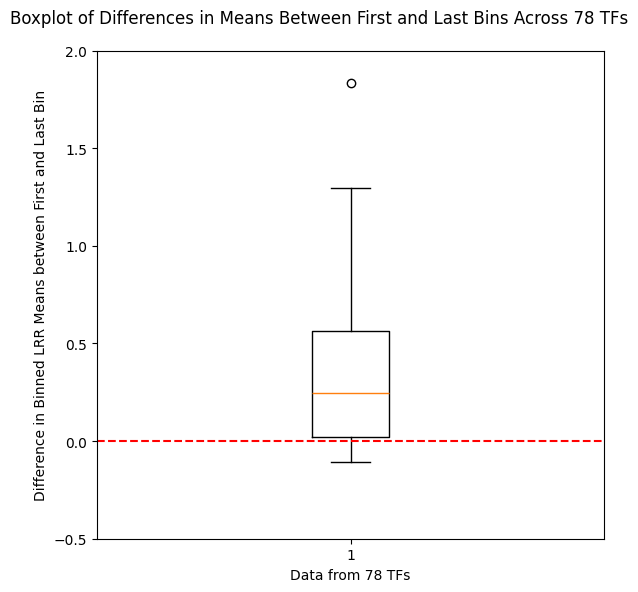

In [88]:
cc_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["mcisaac"], bins = 5)
data = [cc_mcisaac_first_last_data['mcisaac']]
plot_boxplots(data, ["Difference in Binned LRR Means between First and Last Bin"], ["Data from 78 TFs"])

This graph has almost identical axes to the previous graph, except now the x-axis only shows a single value which is just the binned mean differences between the first and last bins. The y-axis is still the binned mean LRR difference between the first and last bin, and the data that generates the boxplot is taken from the 71 TFs used above. This boxplot further reinforces the argument that this general trend holds up across transcription factors. The bottom fence of the boxplot is slightly below zero, indicating that the minimum binned mean difference between the first and last bins can be slightly negative. The third quartile is around 0.5, which, when converted from the logarithmic scale (10^0.5), equates to approximately 3.3. This means that moving from the first bin to the last bin, the average response rank decreases by a factor of about 3.3. For example, if the average response rank in the first bin is 1,000, it decreases to around 300 in the last bin. While this shift may not seem drastic, it is significant enough to be noticeable and demonstrates a consistent trend across different TFs. This trend indicates that the response rank generally decreases as we move from the first bin to the last, highlighting a pattern of decreasing average response ranks in the dataset that contributes to the general upward trend we desire.

Now, let's visualize all of the boxplots creating using combinations of the binding or perturbation dataset in an array format to enable easier visual comparison of how all of the different datasets affect the outcomes of the differences in the first and last bins.

In [40]:
chip_exo_kemmeren_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["kemmeren"], bins = 5)
chip_exo_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["mcisaac"], bins = 5)
chip_exo_hu_reimann_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["hu_reimann"], bins = 5)

In [41]:
new_cc_kemmeren_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["kemmeren"], bins = 5)
new_cc_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["mcisaac"], bins = 5)
new_cc_hu_reimann_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["hu_reimann"], bins = 5)

In [42]:
new_harbison_kemmeren_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["harbison"]*100, perturbation_sources = ["kemmeren"], bins = 5)
new_harbison_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["harbison"]*100, perturbation_sources = ["mcisaac"], bins = 5)
new_harbison_hu_reimann_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["harbison"]*100, perturbation_sources = ["hu_reimann"], bins = 5)

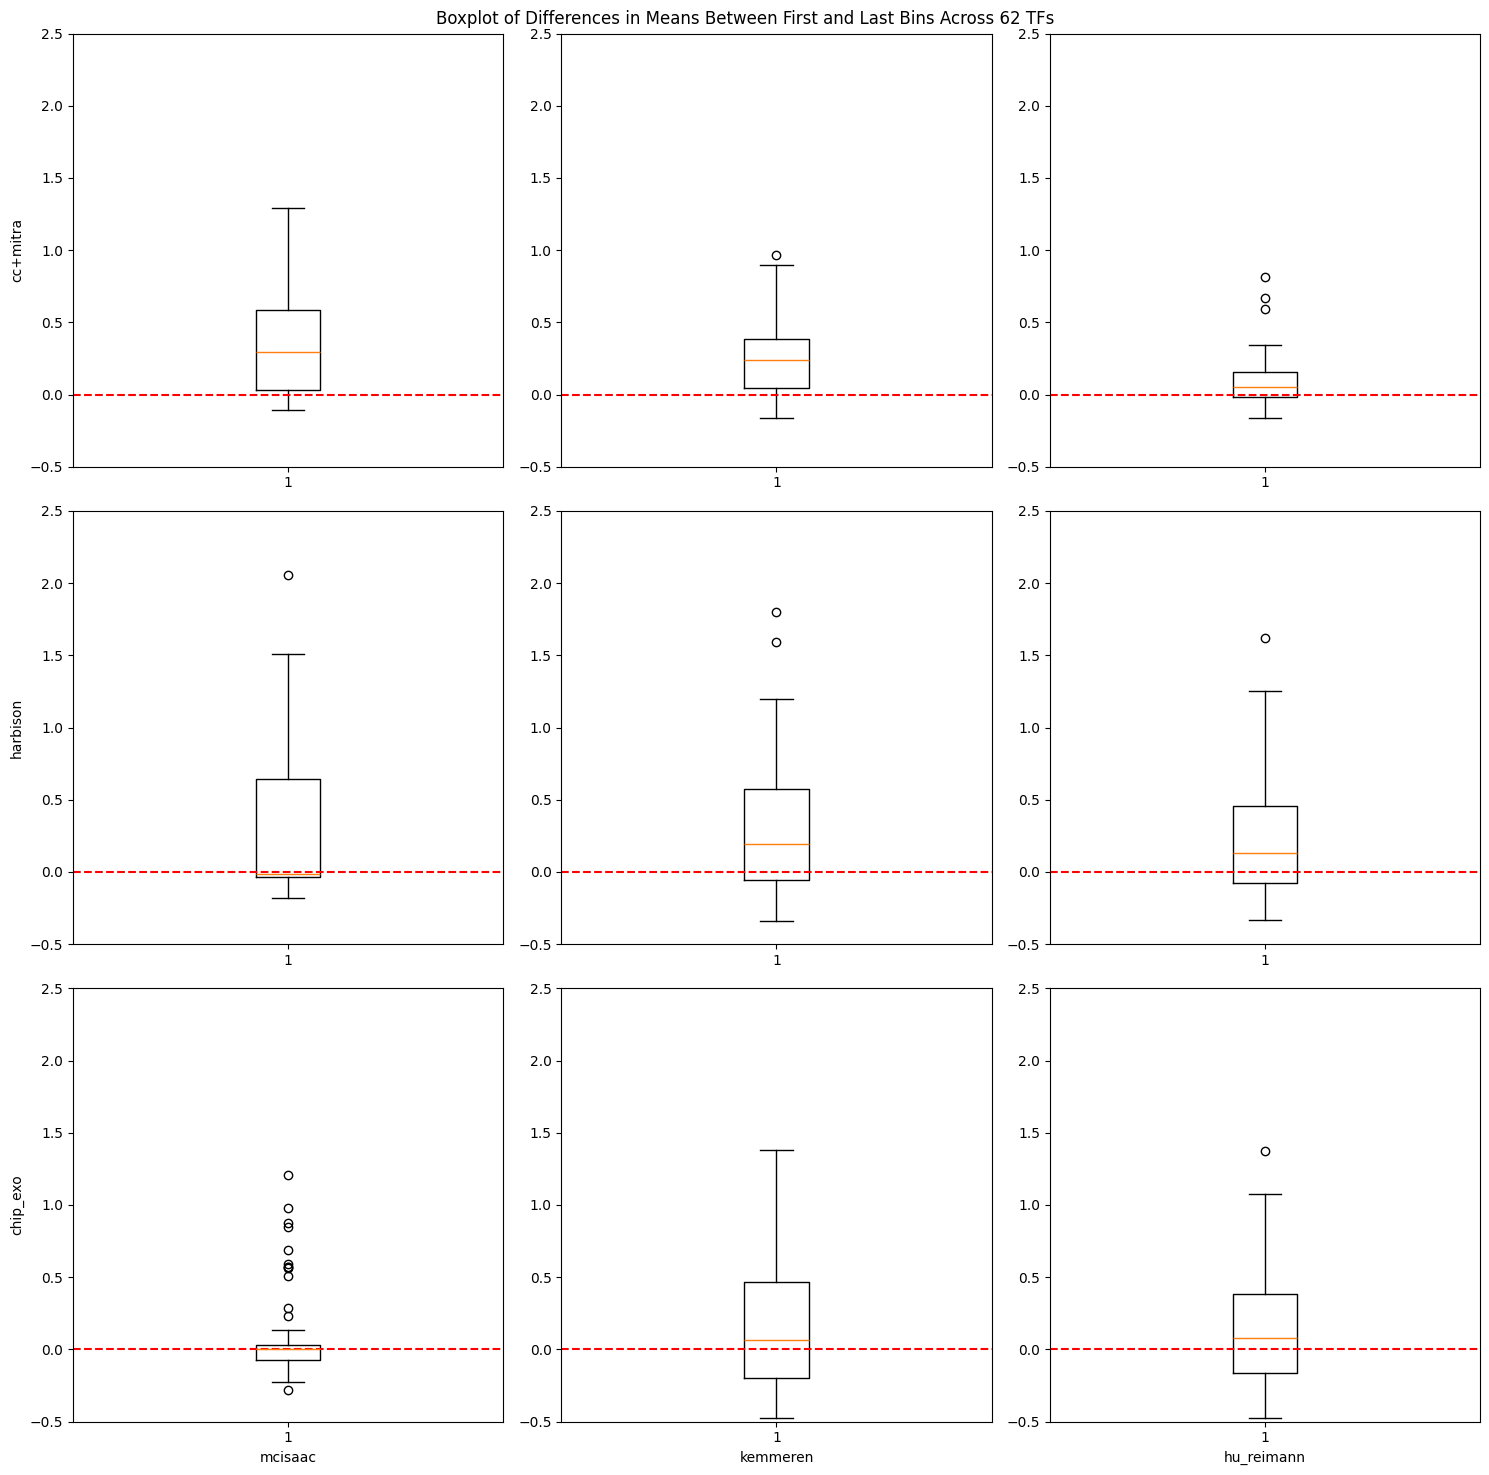

In [44]:
data = [new_cc_mcisaac_first_last_data['mcisaac'], new_cc_kemmeren_first_last_data['kemmeren'],  new_cc_hu_reimann_first_last_data['hu_reimann'], new_harbison_mcisaac_first_last_data['mcisaac'], new_harbison_kemmeren_first_last_data['kemmeren'], new_harbison_hu_reimann_first_last_data['hu_reimann'], chip_exo_mcisaac_first_last_data["mcisaac"], chip_exo_kemmeren_first_last_data["kemmeren"], chip_exo_hu_reimann_first_last_data["hu_reimann"]]
binding_labels = ["cc+mitra", "harbison", "chip_exo"]
perturbation_labels = ["mcisaac", "kemmeren", "hu_reimann"]
plot_boxplots(data, binding_labels, perturbation_labels, "diffs")

This 3x3 array of boxplots displays the distribution of first and last bin mean differences across a common pool of 62 TFs for the 9 combinations of binding and perturbation data. The x and y-axis labels represent the corresponding binding or perturbation dataset used, respectively. For instance, the boxplot at the top right represents the boxplot of the data of the first and last bin mean differences across 62 TFs using the Calling Cards binding data and the hu_reimann perturbation data. So, in short, you can trace the binding and perturbation data used for a particular boxplot by identifying the corresponding labels on the x and y-axis which intersect at this particular boxplot. 

Now, let us examine these plots closer. For convenience, we will look at the trends within a particular row, which means looking at how the binding datasets perform relative to one another across the 3 perturbation datasets. Starting with the top row, in which all of the boxplots are created using the Calling Cards binding data, It is evident that a majority of the data in each boxplot displays a positive difference in the first and last bin means. This is important because it helps to confirm that across the various perturbation datasets used, when using the Calling Cards binding data, a generally positive difference is observed across the first and last bin means. 

Looking at the second row, which represents using the Harbison data, overall it seems to hold up the same trend. However, for the boxplot which uses the mcisaac perturbation data, it is interesting to note that around half of the data does not depict a positive trend. Additionally, for the other two boxplots in this row, which less of the data is positive, there is a greater spread of positive data than there was in the previous row using the Calling Cards data. 

Lastly, in the bottom row, which uses the chip_exo binding data, it is clear that using this binding data set produces the least desirable trends. In the boxplot which uses the mcisaac dataset, it appears that nearly half of the data is non-positive similar to the boxplot directly above it. Additionally, for the other two boxplots within this row, while more than half of the data shows a positive difference, it seems to be barely more than half, and in general seems to depict a weaker positive bin mean difference in comparison to the other two rows above it.

Overall, however, these boxplots help to show that the various combinations of binding and perturbation datasets do show a positive bin mean difference, which is desirable. Of them, the Calling Cards binding dataset and the harbison binding dataset produce more positive distributions of the first and last bin mean difference data compared to the chip_exo binding dataset.

Therefore, might also be interested in seeing how the chip_exo binding data in particular can be augmented to give a potentially more accurate look at its binding data in combination with the perturbation datasets. This is because with the chip_exo binding data in particular, when accessing the data, it only returns genes that were responsive to the transcription factor binding. This essentially means that in comparison to the Calling Cards or harbison data, which may have ~6000 rows of data when initially accessed, the chip_exo data often has less than 100 rows of data. To make the chip_exo data more reflective of both responsive and non-responsive transcription factor binding events, we can add additional rows of data for each gene not included in the original chip_exo dataset for a particular TF based on genes that exist in the perturbation dataset chosen, setting the enrichment score to be 0, and the p-value of binding to be the smallest insignificant p-value. Our modification to the process_transcription_factor_async method below achieves this goal. We can then graph the boxplots again to evaluate how these boxplots incorporating the new chip_exo augmented dataset are different from the ones above.

In [31]:
async def process_transcription_factor_async(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_source: str, pseudocount: int = 1) -> pd.DataFrame:    
    """
    Process transcription factor data by retrieving and merging binding and perturbation datasets.

    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param is_aggregated: Indicates whether the data is aggregated.
    :type is_aggregated: bool
    :param binding_source: The source of the binding data, e.g., "cc" or "harbison".
    :type binding_source: str
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional

    :returns: A DataFrame containing the combined and processed binding and perturbation data.
    :rtype: pd.DataFrame
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for binding data
    pss_api_tf = PromoterSetSigAPI()

    # Access the relevant data depending on the binding source and aggregation status
    if binding_source == "cc":
        if is_aggregated:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
        else:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    elif binding_source == "harbison":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "4"})
    elif binding_source == "mitra":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "2"})
    elif binding_source == "chip_exo":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "3"})

    # Asynchronously read the binding data from the API
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    # Get the ID of the retrieved binding data
    id = tf_pss.get("metadata")["id"][0]
    # Extract the binding data using the ID
    binding_df = tf_pss.get("data").get(str(id))

    # Initialize API for perturbation data
    expression = ExpressionAPI()

    # Map perturbation source to corresponding source number
    source_mapping = {
        "mcisaac": "7",
        "hu_reimann": "5",
        "kemmeren": "6"
    }
    source_number = source_mapping.get(perturbation_source, "unknown")
    
    # Push parameters to retrieve the perturbation data
    if perturbation_source == "mcisaac":
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number, "time": "15"})
    else:
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number})

    # Asynchronously read the perturbation data from the API
    expression_res = await expression.read(retrieve_files=True)
    # Get the ID of the retrieved perturbation data
    id = expression_res.get("metadata")["id"][0]
    # Extract the perturbation data using the ID
    expression_df = expression_res.get("data").get(str(id))

    # Read perturbation data
    perturbation_data = expression_df
    # Read binding data
    binding_data = binding_df

    # Rename columns in binding data for consistency and clarity
    if binding_source == "cc":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "harbison":
        binding_data.rename(columns={"pval": "pvalue"}, inplace=True)
    elif binding_source == "mitra":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "chip_exo":
        binding_data.rename(columns={"max_fc": "effect", "min_pval": "pvalue"}, inplace=True)

    # Optional: here you can modify the pseudocount as needed. The default pseudocount is set to 1.
    # Calculate the effect size for binding data using the provided formula
    if binding_source == "cc":
        binding_data['effect'] = (binding_data['experiment_hops'] / binding_data['experiment_total_hops']) / \
                             ((binding_data['background_hops'] + pseudocount) / binding_data['background_total_hops'])

    missing_values = set(perturbation_data["target_locus_tag"]) - set(binding_data["target_locus_tag"])

    # Add missing rows to the binding data with enrichment = 0 and pvalue = 1
    if missing_values:
        missing_rows = pd.DataFrame({
            'target_locus_tag': list(missing_values),
            'effect': 0,
            'pvalue': -4.322 #since this is for the chipexo data, we find log2 (0.05) 
        })
        binding_data = pd.concat([binding_data, missing_rows], ignore_index=True)

    # Merge the binding data and perturbation data on the 'target_locus_tag' column
    combined_data = pd.merge(binding_data, perturbation_data, on='target_locus_tag', suffixes=('_binding', '_perturbation'))

    # # Assert that the length of combined_data is the minimum of the lengths of binding_data and perturbation_data
    # assert len(combined_data) <= min(len(binding_data), len(perturbation_data)), \
    #     f"Length of combined_data ({len(combined_data)}) is not equal to the minimum of lengths of binding_data ({len(binding_data)}) and perturbation_data ({len(perturbation_data)})"

    # Keep only the necessary columns in the combined data
    combined_data = combined_data[['target_locus_tag', 'effect_binding', 'effect_perturbation', 'pvalue_binding']]

    # Reorder the combined data by the smallest 'pvalue_binding' values
    combined_data = combined_data.sort_values(by='pvalue_binding')

    # Apply transformations:
    # - Take the absolute value of 'effect_perturbation'
    # - Calculate the negative log10 of 'pvalue_binding'
    # - Calculate the log10 of 'effect_binding'
    combined_data['effect_perturbation'] = combined_data['effect_perturbation'].abs()
    combined_data['neg_log_pvalue_binding'] = -np.log10(combined_data['pvalue_binding'])
    combined_data['log_enrichment'] = np.log10(combined_data['effect_binding'])

    # Return the processed combined data as a DataFrame
    return combined_data


In [25]:
filled_chip_exo_kemmeren_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["kemmeren"], bins = 5)
filled_chip_exo_mcisaac_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["mcisaac"], bins = 5)
filled_chip_exo_hu_reimann_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["hu_reimann"], bins = 5)

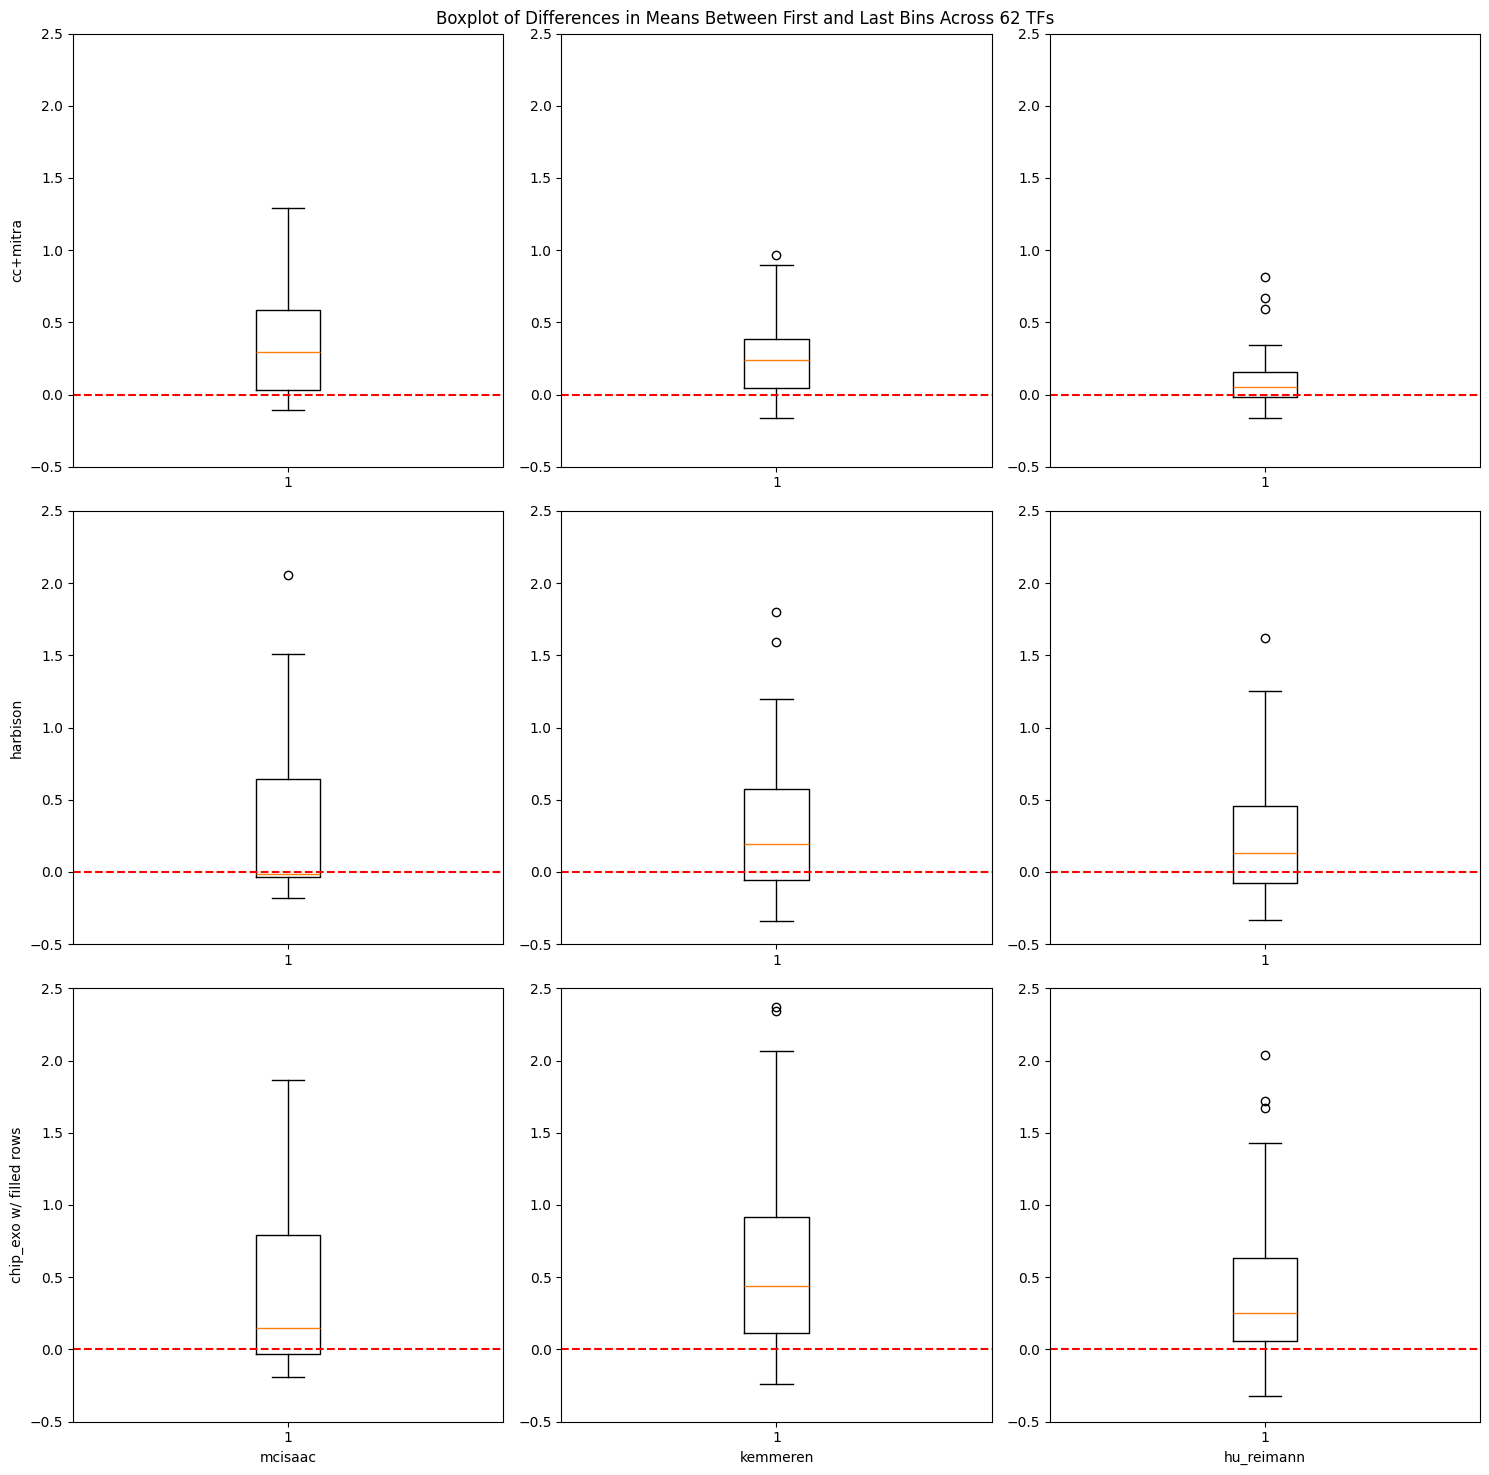

In [32]:
# Keeping the first 2 rows of boxplots the same, we now plot the updated chip_exo related boxplots on the bottom row to compare
data = [new_cc_mcisaac_first_last_data['mcisaac'], new_cc_kemmeren_first_last_data['kemmeren'],  new_cc_hu_reimann_first_last_data['hu_reimann'], new_harbison_mcisaac_first_last_data['mcisaac'], new_harbison_kemmeren_first_last_data['kemmeren'], new_harbison_hu_reimann_first_last_data['hu_reimann'], filled_chip_exo_mcisaac_first_last_data["mcisaac"], filled_chip_exo_kemmeren_first_last_data["kemmeren"], filled_chip_exo_hu_reimann_first_last_data["hu_reimann"]]
binding_labels = ["cc+mitra", "harbison", "chip_exo w/ filled rows"]
perturbation_labels = ["mcisaac", "kemmeren", "hu_reimann"]
plot_boxplots(data, binding_labels, perturbation_labels, "diffs")

This 3x3 array of boxplots is almost identical to the one above, save for the last row which has been updated to reflect the changes made to the chip_exo dataset. However, these changes seem to produce a more positive bin mean difference which is evident by comparing each boxplot with its previous boxplot in the above 3x3 array. For instance, the previous boxplot which utilized the mcisaac perturbation data had less than half of the data depict a positive differnece. Here, however, it is evident that more than half - nearly 75% of the data - depicts a positive difference between the first and last bin means. Similarly, in the boxplots using the kemmeren and hu_reimann perturbation datasets, the lower quartiles of the data in both boxplots are positive, which compared to the previous boxplots is an improvement, as those boxplots showed less than 75% of the data having a positive bin mean difference. Overall, this change to the chip_exo binding data in which the binning process is performed on tends to produce more positive differences, suggesting a potentially better correlation between the LRR and LRB.

### **Boxplots of Pearson Correlations between LRR and LRB**

We can alternatively explore using the Pearson correlation coefficient as another means of documenting this relationship between the LRR and LRB. We will plot a similar array of boxplots like the one above, however, this time we will aggregate the Pearson correlation coefficients for the LRR vs. LRB across all TFs to determine whether there exists a similar positive trend here. To do this, we will need to define some new ways to process the data and obtain the correlation coefficients. Then, we will again create an array of these boxplots in the same format as above to compare the results.

#### Code

In [46]:
def save_pearson_correlation_box_plot_comparisons(tfs: List[str], boolean_list: List[bool], binding_source: List[str], perturbation_sources: List[str], pseudocount: Optional[int] = 1) -> dict:
    """
    Calculates the Pearson correlation coefficient between the 'LRR' and 'LRB' columns for each transcription factor (TF) across multiple perturbation sources.
    
    :param tfs: A list of transcription factors to analyze.
    :type tfs: List[str]
    :param boolean_list: A list of boolean values indicating whether the data is aggregated for each transcription factor.
    :type boolean_list: List[bool]
    :param binding_source: A list of sources for the binding data.
    :type binding_source: List[str]
    :param perturbation_sources: A list of sources for the perturbation data.
    :type perturbation_sources: List[str]
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: Optional[int]
    
    :returns: A dictionary where keys are perturbation sources and values are lists of Pearson correlation coefficients for each TF.
    :rtype: Dict[str, List[float]]
    """
    # Initialize a dictionary to store Pearson correlation coefficients for each perturbation source
    correlation_data = {source: [] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            for source in perturbation_sources:
                # Process the transcription factor data
                combined_data = process_transcription_factor(str(tfs[i]), boolean_list[i], binding_source[i], source, pseudocount)

                # Further process the combined data to calculate ranks and transformations
                plotting_df = process_dataframe(combined_data)

                # Ensure there are no NaN values in the 'LRR' and 'LRB' columns before calculating Pearson correlation
                plotting_df = plotting_df.dropna(subset=['neg_log_rank_binding', 'neg_expression_rank_log'])

                # Calculate Pearson correlation if there are at least two valid data points
                if len(plotting_df) >= 2:
                    correlation, _ = pearsonr(plotting_df['neg_log_rank_binding'], plotting_df['neg_expression_rank_log'])
                    correlation_data[source].append(correlation)
                else:
                    correlation_data[source].append(float('nan'))
                print("TF: {}, correlation: {}".format(tfs[i], correlation))
    # Remove NaN values from all correlation lists
    for source in correlation_data:
        correlation_data[source] = [x for x in correlation_data[source] if not pd.isnull(x)]

    return correlation_data

def compare_pearson_correlation_stored_data_box_plots(stored_data_list: List[dict], labels: List[str]) -> None:
    """
    Generates a box plot comparing multiple sets of stored data.
    
    :param stored_data_list: A list of dictionaries containing stored data for each perturbation source.
    :type stored_data_list: List[dict]
    :param labels: A list of labels corresponding to each set of stored data.
    :type labels: List[str]
    
    :returns: None
    :rtype: None
    """
    plt.figure(figsize=(10, 6))
    boxplot_data = []
    xtick_labels = []

    for idx, stored_data in enumerate(stored_data_list):
        for source, data in stored_data.items():
            boxplot_data.append(data)
            xtick_labels.append(f'{labels[idx]}')

    plt.boxplot(boxplot_data, widths=0.6)
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel('Perturbation Sources')  
    plt.ylabel('Pearson Correlation Between LRB and LRR')  
    plt.title('Comparison of Pearson Correlation Between LRB and LRR Across Multiple TFs')
    
    plt.xticks(ticks=range(1, len(xtick_labels) + 1), labels=xtick_labels, rotation=90)
    plt.show()

#### Application

Now that we've defined the methods, let's run them on the dataset of 62 TFs and compare the boxplots between the combinations of perturbating and binding data.

In [ ]:
all_tfs = ['WTM1','MIG2','RIM101','GZF3','ASH1','TEC1','SIP3','SKN7','WTM2','HAA1','MET31','CRZ1','CHA4','ZAP1','SKO1','FZF1','HAP2','HAP3','HAP5','INO4','RTG1','MOT3','CBF1','MSN2','RTG3','RSF2','HIR2','SIP4','UME1','CIN5','ROX1','XBP1','RDR1','PDR3','RLM1','SFL1','SMP1','PHD1','SUT1','SOK2','STP2','AFT2','YRR1','GAL4','LEU3','SWI6','ACE2','RGM1','GCN4','MIG3','STB5','RFX1','ARG81','AZF1','SFP1','GTS1','FKH1','YOX1','FKH2','DIG1','MET28','RGT1']
boolean_list = [True]*31 + [False]*31
cc_to_mitra_ratio_in_all = ["cc"]*38+["mitra"]*24

In [ ]:
#saving the data to plot as a joint boxplot
new_cc_kemmeren_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["kemmeren"])
new_cc_mcisaac_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["mcisaac"])
new_cc_hu_reimann_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["hu_reimann"])

In [ ]:
new_harbison_kemmeren_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["harbison"]*100, perturbation_sources = ["kemmeren"])
new_harbison_mcisaac_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["harbison"]*100, perturbation_sources = ["mcisaac"])
new_harbison_hu_reimann_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["harbison"]*100, perturbation_sources = ["hu_reimann"])

In [ ]:
chip_exo_kemmeren_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["kemmeren"])
chip_exo_mcisaac_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["mcisaac"])
chip_exo_reimann_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["hu_reimann"])

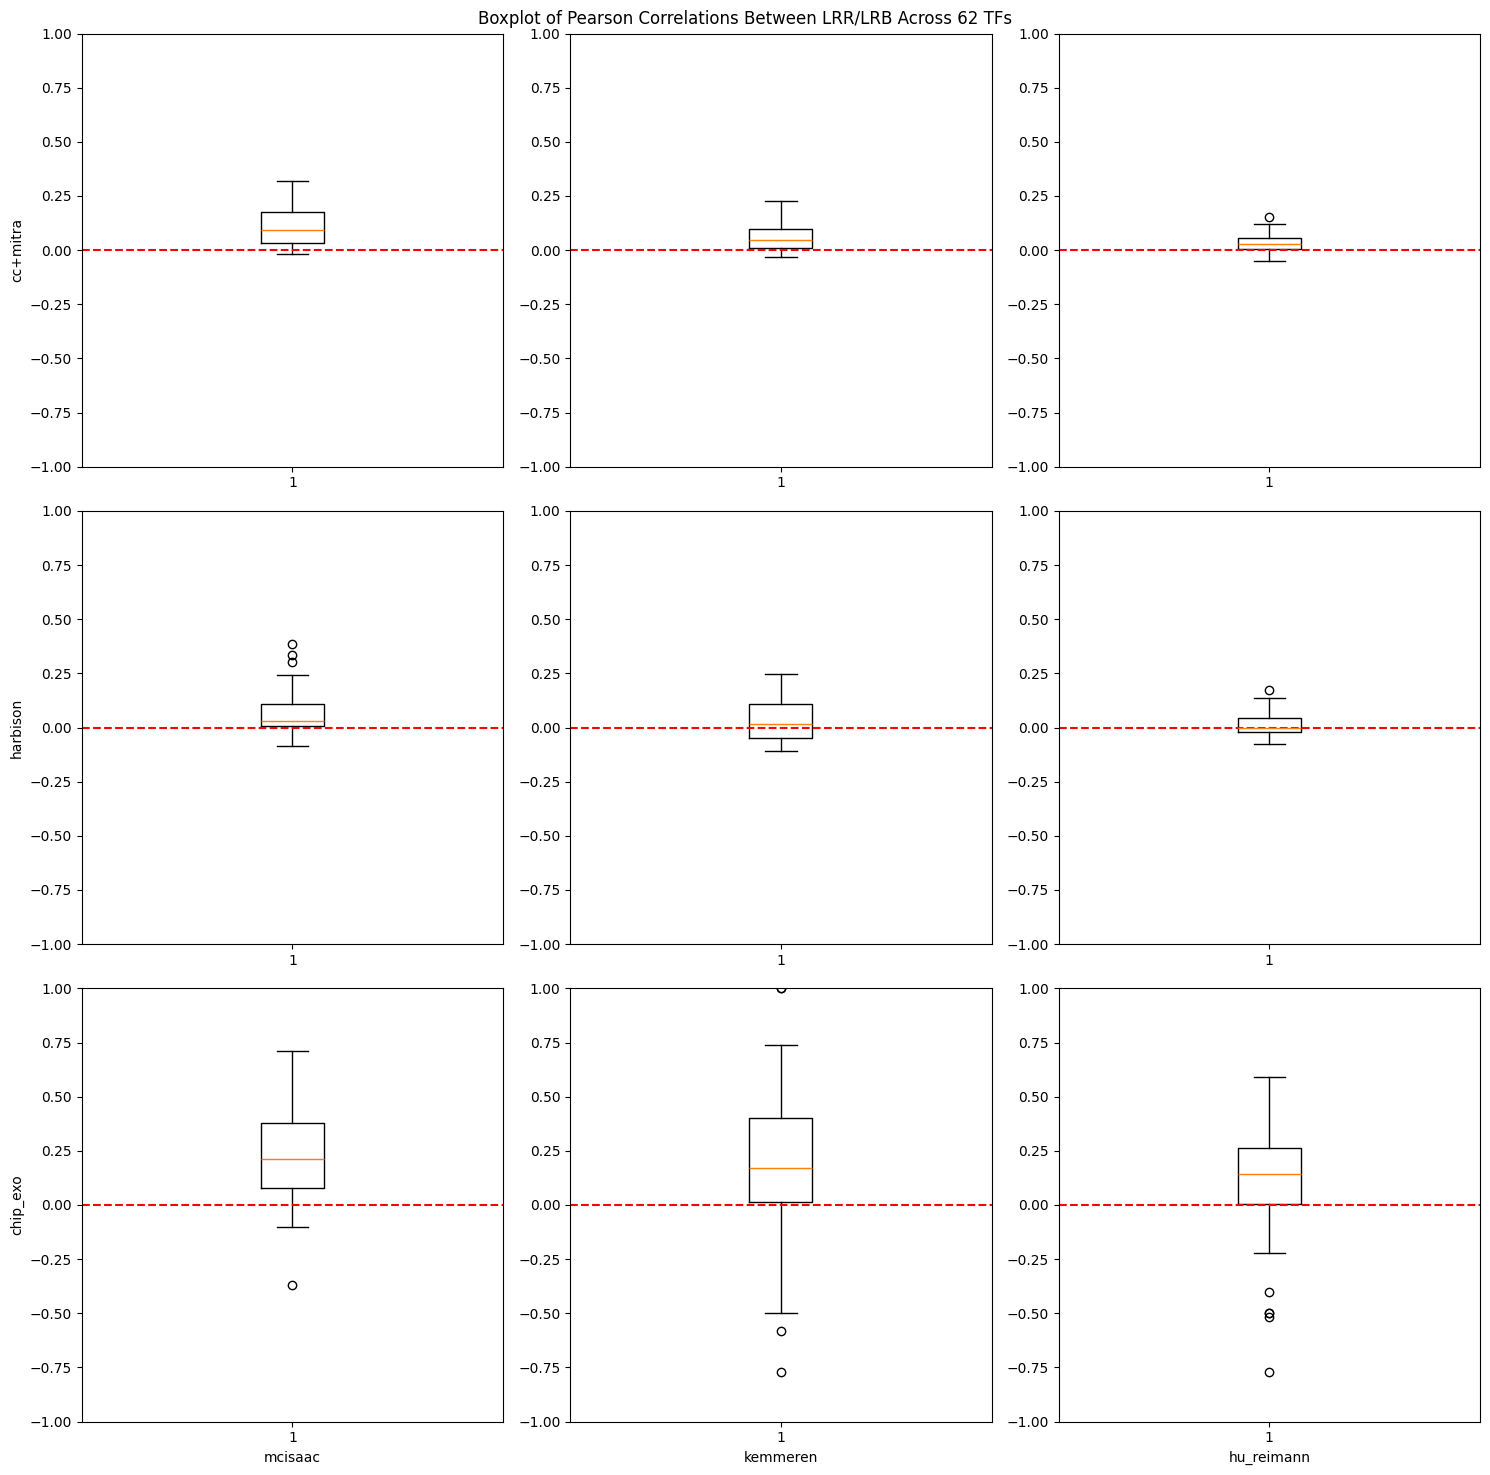

In [382]:
data = [new_cc_mcisaac_pearson_correlations['mcisaac'], new_cc_kemmeren_pearson_correlations['kemmeren'], new_cc_hu_reimann_pearson_correlations['hu_reimann'], new_harbison_mcisaac_pearson_correlations['mcisaac'], new_harbison_kemmeren_pearson_correlations['kemmeren'], new_harbison_hu_reimann_pearson_correlations['hu_reimann'],chip_exo_mcisaac_pearson_correlations['mcisaac'], chip_exo_kemmeren_pearson_correlations['kemmeren'], chip_exo_reimann_pearson_correlations['hu_reimann']]
binding_labels = ["cc+mitra", "harbison", "chip_exo"]
perturbation_labels = ["mcisaac", "kemmeren", "hu_reimann"]
plot_boxplots(data, binding_labels, perturbation_labels, "correlations")

This boxplot is organized exactly the same as the boxplots above. However, in this case, the data being plotted by the boxplots is using the pearson correlation between the LRR and LRB values for a particular TF, aggregating this data across all 62 TFs.

This exhibits a similar overall trend with the 3x3 arrays of boxplots above containing the binned mean differences between the first and last bins. This is good news! It means that even without binning, there is somewhat of a trend observed between the LRR and LRB, even if it is not very significant. Looking at the boxplots, it appears that this trend is generally most evident in the chip_exo binding data. However, it is important to clarify that the chip_exo data has less than 100 rows of data in general. This means that for example, in the boxplot using the kemmeren perturbation data, a perfect correlation of 1.00 is achieved. Upon closer examination, this is due to the fact that the chip_exo data had only 2 rows of data associated with it, and when ranking the LRR and LRB, they both were assigned the same ranks resulting in a perfect pearson correlation. As such, it is important to keep in mind the property of the chip_exo binding data when assessing the plots in the bottom row as they may look much better than reality.

Looking at the other two rows, it is more evident that the Calling Cards + mitra binding datasets produce better correlations than using the harbison binding data, as the medians of the boxplots in the top row are all greater than zero, whereas only one median in the bottom row is positive. It also seems that using the CC + mitra binding data and the kemmeren perturbation data yields the most identifiable trend within that row, while the harbison binding and mcisaac perturbation data produce the most positive correlations in that row. 

To obtain a more accurate idea of how the Pearson correlation boxplots should look like by incorporating data on the non-responsive genes for the chip_exo binding data, we can take the same approach used to create the boxplots above and modify the method in which the chip_exo data is accessed in order to include non-responsive data points for all of the non-responsive genes. Keep in mind that the enrichment and pvalues are chosen to be 0 and the smallest insignificant pvalue of 0.05, respectively. We will re-plot the 3x3 array of Pearson correlation boxplots to determine how the bottom row of boxplots will change.

In [ ]:
async def process_transcription_factor_async(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_source: str, pseudocount: int = 1) -> pd.DataFrame:    
    """
    Process transcription factor data by retrieving and merging binding and perturbation datasets.

    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param is_aggregated: Indicates whether the data is aggregated.
    :type is_aggregated: bool
    :param binding_source: The source of the binding data, e.g., "cc" or "harbison".
    :type binding_source: str
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional

    :returns: A DataFrame containing the combined and processed binding and perturbation data.
    :rtype: pd.DataFrame
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for binding data
    pss_api_tf = PromoterSetSigAPI()

    # Access the relevant data depending on the binding source and aggregation status
    if binding_source == "cc":
        if is_aggregated:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
        else:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    elif binding_source == "harbison":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "4"})
    elif binding_source == "mitra":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "2"})
    elif binding_source == "chip_exo":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "3"})

    # Asynchronously read the binding data from the API
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    # Get the ID of the retrieved binding data
    id = tf_pss.get("metadata")["id"][0]
    # Extract the binding data using the ID
    binding_df = tf_pss.get("data").get(str(id))

    # Initialize API for perturbation data
    expression = ExpressionAPI()

    # Map perturbation source to corresponding source number
    source_mapping = {
        "mcisaac": "7",
        "hu_reimann": "5",
        "kemmeren": "6"
    }
    source_number = source_mapping.get(perturbation_source, "unknown")
    
    # Push parameters to retrieve the perturbation data
    if perturbation_source == "mcisaac":
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number, "time": "15"})
    else:
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number})

    # Asynchronously read the perturbation data from the API
    expression_res = await expression.read(retrieve_files=True)
    # Get the ID of the retrieved perturbation data
    id = expression_res.get("metadata")["id"][0]
    # Extract the perturbation data using the ID
    expression_df = expression_res.get("data").get(str(id))

    # Read perturbation data
    perturbation_data = expression_df
    # Read binding data
    binding_data = binding_df

    # Rename columns in binding data for consistency and clarity
    if binding_source == "cc":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "harbison":
        binding_data.rename(columns={"pval": "pvalue"}, inplace=True)
    elif binding_source == "mitra":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "chip_exo":
        binding_data.rename(columns={"max_fc": "effect", "min_pval": "pvalue"}, inplace=True)

    # Optional: here you can modify the pseudocount as needed. The default pseudocount is set to 1.
    # Calculate the effect size for binding data using the provided formula
    if binding_source == "cc":
        binding_data['effect'] = (binding_data['experiment_hops'] / binding_data['experiment_total_hops']) / \
                             ((binding_data['background_hops'] + pseudocount) / binding_data['background_total_hops'])

    missing_values = set(perturbation_data["target_locus_tag"]) - set(binding_data["target_locus_tag"])

    # Add missing rows to the binding data with enrichment = 0 and pvalue = 1
    if missing_values:
        missing_rows = pd.DataFrame({
            'target_locus_tag': list(missing_values),
            'effect': 0,
            'pvalue': -4.322 #since this is for the chipexo data, we find log2 (0.05) 
        })
        binding_data = pd.concat([binding_data, missing_rows], ignore_index=True)

    # Merge the binding data and perturbation data on the 'target_locus_tag' column
    combined_data = pd.merge(binding_data, perturbation_data, on='target_locus_tag', suffixes=('_binding', '_perturbation'))

    # # Assert that the length of combined_data is the minimum of the lengths of binding_data and perturbation_data
    # assert len(combined_data) <= min(len(binding_data), len(perturbation_data)), \
    #     f"Length of combined_data ({len(combined_data)}) is not equal to the minimum of lengths of binding_data ({len(binding_data)}) and perturbation_data ({len(perturbation_data)})"

    # Keep only the necessary columns in the combined data
    combined_data = combined_data[['target_locus_tag', 'effect_binding', 'effect_perturbation', 'pvalue_binding']]

    # Reorder the combined data by the smallest 'pvalue_binding' values
    combined_data = combined_data.sort_values(by='pvalue_binding')

    # Apply transformations:
    # - Take the absolute value of 'effect_perturbation'
    # - Calculate the negative log10 of 'pvalue_binding'
    # - Calculate the log10 of 'effect_binding'
    combined_data['effect_perturbation'] = combined_data['effect_perturbation'].abs()
    combined_data['neg_log_pvalue_binding'] = -np.log10(combined_data['pvalue_binding'])
    combined_data['log_enrichment'] = np.log10(combined_data['effect_binding'])

    # Return the processed combined data as a DataFrame
    return combined_data


In [ ]:
filled_chip_exo_kemmeren_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["kemmeren"])
filled_chip_exo_mcisaac_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["mcisaac"])
filled_chip_exo_reimann_pearson_correlations = save_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, ["chip_exo"]*100, perturbation_sources = ["hu_reimann"])

In [ ]:
#new updating process dataframe
data = [new_cc_mcisaac_pearson_correlations['mcisaac'], new_cc_kemmeren_pearson_correlations['kemmeren'], new_cc_hu_reimann_pearson_correlations['hu_reimann'], new_harbison_mcisaac_pearson_correlations['mcisaac'], new_harbison_kemmeren_pearson_correlations['kemmeren'], new_harbison_hu_reimann_pearson_correlations['hu_reimann'], filled_chip_exo_mcisaac_pearson_correlations['mcisaac'], filled_chip_exo_kemmeren_pearson_correlations['kemmeren'], filled_chip_exo_reimann_pearson_correlations['hu_reimann']]
binding_labels = ["cc+mitra", "harbison", "chip_exo w/ filled rows"]
perturbation_labels = ["mcisaac", "kemmeren", "hu_reimann"]
plot_boxplots(data, binding_labels, perturbation_labels, "correlations")

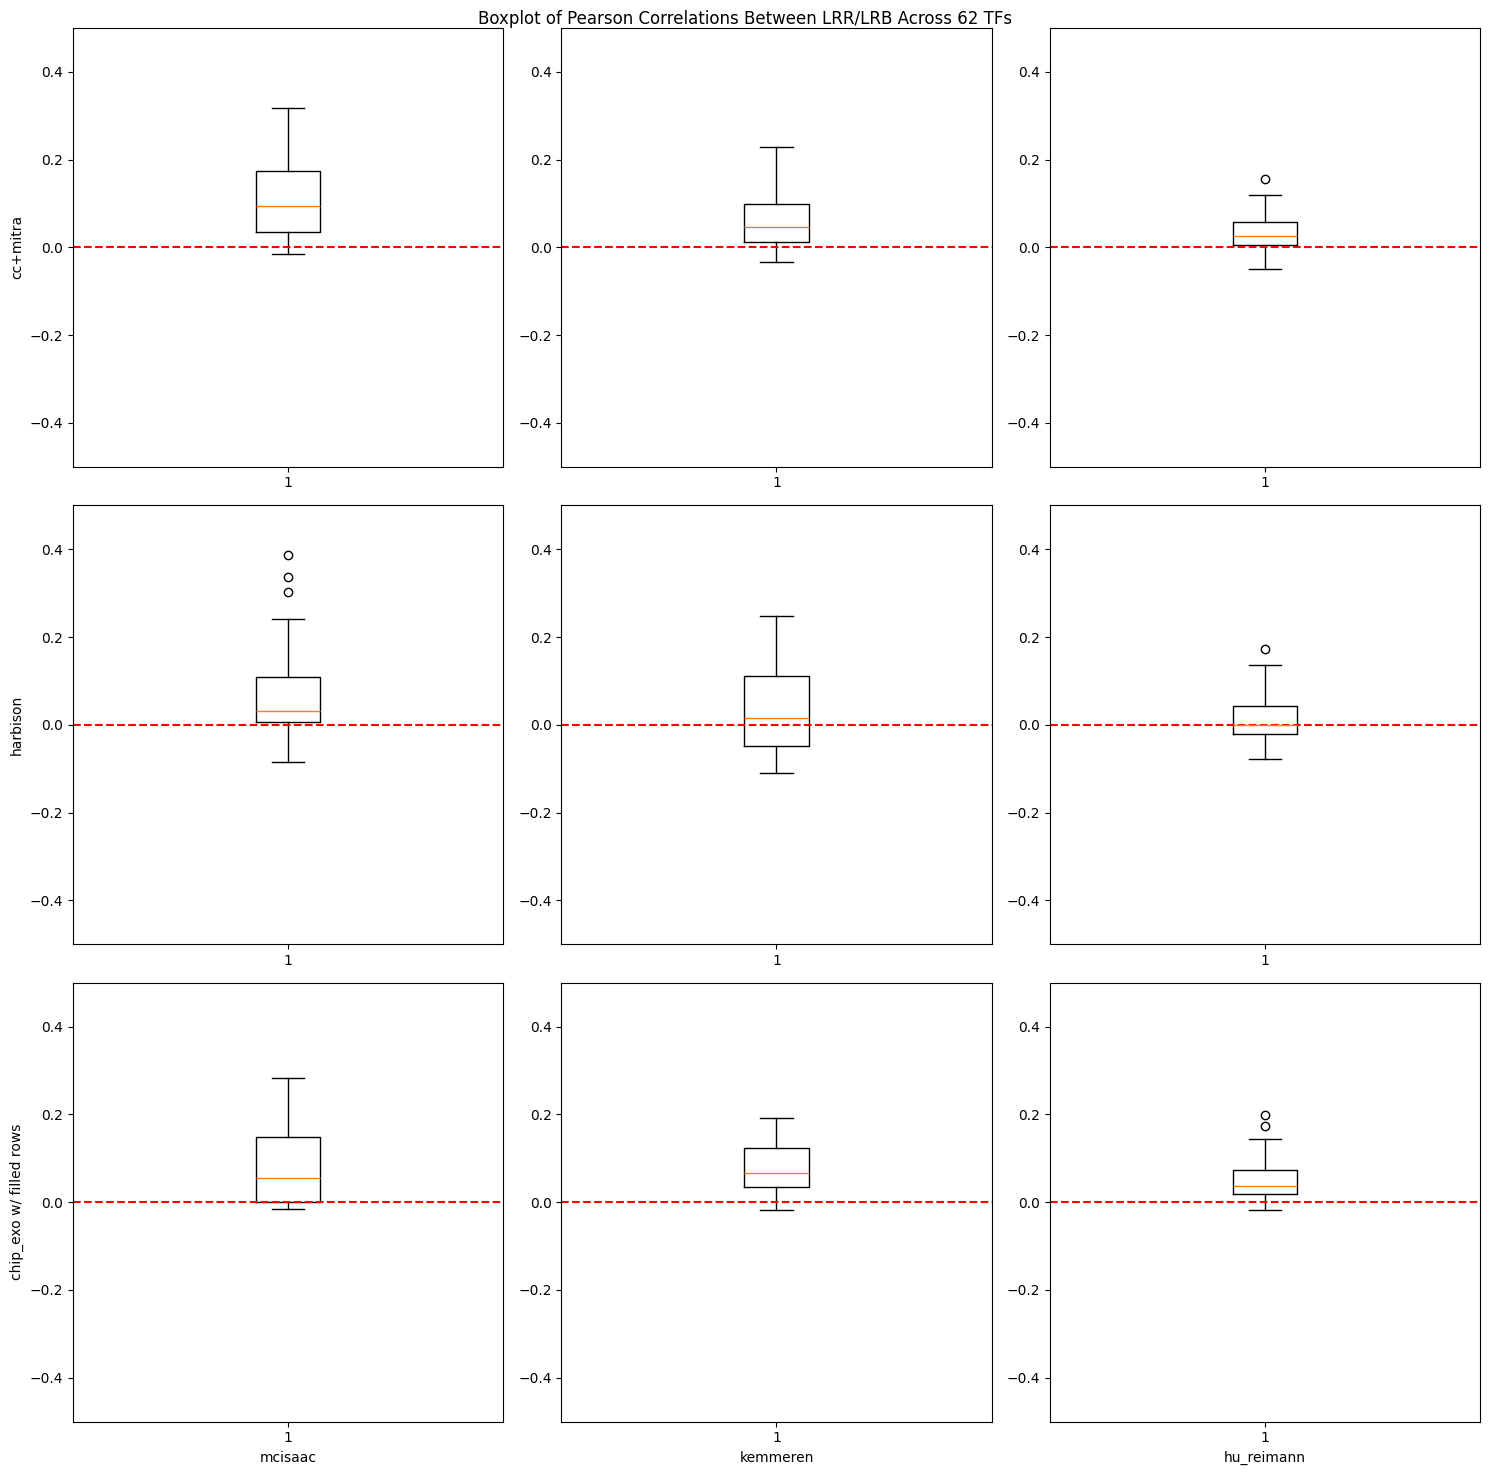

In [383]:
data = [new_cc_mcisaac_pearson_correlations['mcisaac'], new_cc_kemmeren_pearson_correlations['kemmeren'], new_cc_hu_reimann_pearson_correlations['hu_reimann'], new_harbison_mcisaac_pearson_correlations['mcisaac'], new_harbison_kemmeren_pearson_correlations['kemmeren'], new_harbison_hu_reimann_pearson_correlations['hu_reimann'], filled_chip_exo_mcisaac_pearson_correlations['mcisaac'], filled_chip_exo_kemmeren_pearson_correlations['kemmeren'], filled_chip_exo_reimann_pearson_correlations['hu_reimann']]
binding_labels = ["cc+mitra", "harbison", "chip_exo w/ filled rows"]
perturbation_labels = ["mcisaac", "kemmeren", "hu_reimann"]
plot_boxplots(data, binding_labels, perturbation_labels, "correlations")

Before we compare the last row of updated chip_exo data with the 3x3 array of boxplots above, it is important to note that the scale on these two boxplots is not the same. On the above array of boxplots, the vertical scale ranges from -1.00 to 1.00. Here, however, the scale is halved, ranging only from -0.50 to 0.50. With this in mind, it is more apparent that adding the non-responsive genes to the chip_exp binding data results in weaker positive correlations between the LRR and LRB. This is likely due to the fact that many new rows of data representing non-responsible genes have been added, which greatly outnumber the original amount of data in the chip_exo binding data. Thus, these boxplots seem more plausible, and it is good that they continue to show a somewhat positive correlation, albeit not as extreme as before.

## **Further Approaches to Ranking the Binding and Perturbation Data**

Our above analysis focused on ranking the binding and pertubation data in the same way each time. However, due to the nature of the data, there are often identical values which are assigned the same ranking in both the binding and perturbation data.

As a reminder, the binding data was ranked according to the poisson pvalue, even through two other metrics exist: the binding enrichment score and the hypergeometric pvalue. It is worth considering whether alternative ranking approaches can result in less ties and ultimately, more desirable trends as observed on the boxplots of the binned mean data differences and Pearson correlations.

In the data exploration above, we solely chose to rank the perturbation data according to the magnitude of the perturbation effect. For the mcisaac perturbation data specifically, there exist mutiple timepoints in which there is effect data. The idea of assigning ranks to the data by averaging between two perturbation sets is another method that we can explore to determine whether this improve the binned boxplots above. 

### **Which Approaches of Ranking the Perturbation Data Yields the Best Trends?**

#### **1) Using Average Ranking For Multiple Timepoints in the mcisaac Perturbation Data**

It's interesting to consider whether taking an average ranking might result in a stronger trend being depicted on the boxplots for the Pearson correlation or first and last binned mean differences. The motivation for this comes from the fact that in the plots above, the highest value along the y-axis is around -3, and when taking the reverse of the negative log this results in a rank around 1000. If the highest rank is 1000, this implies many ties occuring between data points which can result in a lower resolution of the desired trend. Thus, it is worth exploring whether assigning each gene an average rank across the different timepoints reported in the mcisaac data may produce better rankings. The following methods below will perform this averaging of the ranks on the mcisaac perturbation data across 4 timepoints and then combine the perturbation and binding datasets since the original methods do not support the implementation of this ranking method. Note that we will use the CC + mitra data as the binding data in all of the perturbation ranking experiments.

#### Code

In [71]:
async def process_perturbation_data_async(tf_name: str, perturbation_source: str) -> pd.DataFrame:
    """
    Process perturbation data by retrieving data for different timepoints, ranking genes,
    and calculating the average rank for each gene across timepoints.
    
    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    
    :returns: A DataFrame containing the genes and their average rankings.
    :rtype: pd.DataFrame
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for perturbation data
    expression = ExpressionAPI()
    
    if perturbation_source == "mcisaac":
        timepoints = ["15", "30", "45", "90"]
        all_timepoint_dfs = []

        for time in timepoints:
            source_mapping = {
                "mcisaac": "7",
                "hu_reimann": "5",
                "kemmeren": "6"
            }
            source_number = source_mapping.get(perturbation_source, "unknown")
    
            # Push parameters to retrieve the perturbation data
            if perturbation_source == "mcisaac":
                expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number, "time": "15"})
            else:
                expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number})
            expression_res = await expression.read(retrieve_files=True)
            id = expression_res.get("metadata")["id"][0]
            expression_df = expression_res.get("data").get(str(id))
            expression_df['time'] = time
            expression_df['effect'] = expression_df['effect'].abs()
            all_timepoint_dfs.append(expression_df)

        combined_expression_df = pd.concat(all_timepoint_dfs)

        # Rank genes based on the perturbation effect within each timepoint
        ranked_dfs = []
        for time in timepoints:
            timepoint_df = combined_expression_df[combined_expression_df['time'] == time].copy()
            timepoint_df['rank'] = rankdata(-abs(timepoint_df['effect']), method='average') 
            ranked_dfs.append(timepoint_df)
        
        # Combine ranked dataframes
        ranked_combined_df = pd.concat(ranked_dfs)
        
        avg_ranks = {}
        for gene in ranked_combined_df['target_locus_tag'].unique():
            gene_data = ranked_combined_df[ranked_combined_df['target_locus_tag'] == gene]
            avg_rank = gene_data['rank'].mean()
            avg_effect = gene_data['effect'].mean()
            avg_ranks[gene] = (avg_effect, avg_rank)
        
        avg_ranks_df = pd.DataFrame(list(avg_ranks.items()), columns=['target_locus_tag', 'values'])
        avg_ranks_df[['effect', 'avg_rank']] = pd.DataFrame(avg_ranks_df['values'].tolist(), index=avg_ranks_df.index)
        avg_ranks_df = avg_ranks_df.drop(columns=['values'])
        avg_ranks_df['neg_expression_rank_log'] = -np.log10(avg_ranks_df['avg_rank'])

        return avg_ranks_df

In [72]:
def process_perturbation_data(tf_name: str, perturbation_source: str) -> pd.DataFrame:
    """
    Processes transcription factor data synchronously by invoking an asynchronous function.
    
    This function runs the asynchronous `process_transcription_factor_async` function synchronously to handle 
    transcription factor data processing. It retrieves the event loop, runs the asynchronous function, 
    and returns the processed DataFrame.
    
    :param tf_name: The name of the transcription factor.
    :type tf_name: str
    :param is_aggregated: A boolean flag indicating whether the data is aggregated.
    :type is_aggregated: bool
    :param perturbation_source: The source of the perturbation data.
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional
    
    :returns: A DataFrame containing the processed transcription factor data.
    :rtype: pd.DataFrame
    """
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(process_perturbation_data_async(tf_name, perturbation_source))

In [73]:
async def access_binding_data_async(tf_name: str, is_aggregated: bool, binding_source: str, pseudocount: Optional[int] = 1) -> pd.DataFrame:    
    """
    Process transcription factor data by retrieving and merging binding and perturbation datasets.
    
    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param is_aggregated: Indicates whether the data is aggregated. You can check if the TF belongs to the list above.
    :type is_aggregated: bool
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional
    
    :returns: A DataFrame containing the combined and processed binding and perturbation data.
    :rtype: pd.DataFrame
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for binding data
    pss_api_tf = PromoterSetSigAPI()

    # Access the relevant data depending on whether the data is aggregated or not
    if binding_source == "cc":
        if is_aggregated:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
        else:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    elif binding_source == "harbison":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "4"})
    elif binding_source == "mitra":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "2"})

    # Asynchronously read the binding data from the API
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    # Get the ID of the retrieved binding data
    id = tf_pss.get("metadata")["id"][0]
    # Extract the binding data using the ID
    binding_df = tf_pss.get("data").get(str(id))

    # Calculate binding rank with average ties method
    if binding_source == "cc":
        binding_df['binding_rank'] = rankdata(binding_df['poisson_pval'], method='average')
    elif binding_source == "harbison":
        binding_df['binding_rank'] = rankdata(binding_df['pval'], method='average')
    elif binding_source == "mitra":
        binding_df['binding_rank'] = rankdata(binding_df['poisson_pval'], method='average')

    # Calculate log transform of the binding rank
    binding_df['neg_log_rank_binding'] = -np.log10(rankdata(binding_df['binding_rank'], method='average'))
    
    return binding_df

In [74]:
def access_binding_data(tf_name: str, is_aggregated: bool, binding_source: str, pseudocount: Optional[int] = 1) -> pd.DataFrame:
    """
    Processes transcription factor data synchronously by invoking an asynchronous function.
    
    This function runs the asynchronous `process_transcription_factor_async` function synchronously to handle 
    transcription factor data processing. It retrieves the event loop, runs the asynchronous function, 
    and returns the processed DataFrame.
    
    :param tf_name: The name of the transcription factor.
    :type tf_name: str
    :param is_aggregated: A boolean flag indicating whether the data is aggregated.
    :type is_aggregated: bool
    :param perturbation_source: The source of the perturbation data.
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional
    
    :returns: A DataFrame containing the processed transcription factor data.
    :rtype: pd.DataFrame
    """
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(access_binding_data_async(tf_name, is_aggregated, binding_source, pseudocount))

In [75]:
def process_and_merge_data(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_source: str, pseudocount: Optional[int] = 1) -> pd.DataFrame:
    """
    Process binding and perturbation data and merge them.
    
    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param is_aggregated: Indicates whether the data is aggregated.
    :type is_aggregated: bool
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional
    
    :returns: Merged DataFrame with the specified columns.
    :rtype: pd.DataFrame
    """
    binding_df = access_binding_data(tf_name, is_aggregated, binding_source, pseudocount)
    perturbation_df = process_perturbation_data(tf_name, perturbation_source)
    # Merge the dataframes on 'regulator_locus_tag'
    merged_df = pd.merge(binding_df, perturbation_df, on='target_locus_tag')
    
    # Select the desired columns
    result_df = merged_df[['target_locus_tag', 'neg_log_rank_binding', 'neg_expression_rank_log']]    
    return result_df

In [307]:
#this is how you would access the combined binding / perturbation data using this ranking approach
combined_data = process_and_merge_data("ARO80", False, "cc", "mcisaac")
combined_data.head()

,target_locus_tag,neg_log_rank_binding,neg_expression_rank_log
0,YAL069W,-3.231470,-3.495128
1,YAL068C,-3.056524,-3.495128
2,YAL067C,-3.160769,-3.495128
3,YAL066W,-2.957847,-3.495128
4,YAL065C,-2.548389,-3.495128


Let's investigate the correlations between the LRR and LRB when ranking according to this scheme. We will need to create slightly different methods to accomodate for this new way of ranking the data.

In [36]:
def save_ranked_pearson_correlation_box_plot_comparisons(tfs: List[str], boolean_list: List[bool], binding_source: List[str], perturbation_sources: List[str], pseudocount: Optional[int] = 1) -> dict:
    """
    Calculates the Pearson correlation coefficient between the 'LRR' and 'LRB' columns for each transcription factor (TF) across multiple perturbation sources.
    
    :param tfs: A list of transcription factors to analyze.
    :type tfs: List[str]
    :param boolean_list: A list of boolean values indicating whether the data is aggregated for each transcription factor.
    :type boolean_list: List[bool]
    :param binding_source: A list of sources for the binding data.
    :type binding_source: List[str]
    :param perturbation_sources: A list of sources for the perturbation data.
    :type perturbation_sources: List[str]
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: Optional[int]
    
    :returns: A dictionary where keys are perturbation sources and values are lists of Pearson correlation coefficients for each TF.
    :rtype: Dict[str, List[float]]
    """
    # Initialize a dictionary to store Pearson correlation coefficients for each perturbation source
    correlation_data = {source: [] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            for source in perturbation_sources:
                # Further process the combined data to calculate ranks and transformations
                plotting_df = process_and_merge_data(str(tfs[i]), boolean_list[i], binding_source[i], source, pseudocount)

                # Ensure there are no NaN values in the 'LRR' and 'LRB' columns before calculating Pearson correlation
                plotting_df = plotting_df.dropna(subset=['neg_log_rank_binding', 'neg_expression_rank_log'])

                # Calculate Pearson correlation if there are at least two valid data points
                if len(plotting_df) >= 2:
                    correlation, _ = pearsonr(plotting_df['neg_log_rank_binding'], plotting_df['neg_expression_rank_log'])
                    correlation_data[source].append(correlation)
                else:
                    correlation_data[source].append(float('nan'))

    # Remove NaN values from all correlation lists
    for source in correlation_data:
        correlation_data[source] = [x for x in correlation_data[source] if not pd.isnull(x)]

    return correlation_data


In [ ]:
def adjacent_differences_store_ranked_data(tfs: List[str], boolean_list: List[bool], binding_source: List[str], perturbation_sources: List[str], bins: int, pseudocount: Optional[int] = 1) -> dict:
    """
    Stores the differences between adjacent bins for a list of transcription factors.
    
    This function processes transcription factor data, calculates differences between the means of adjacent bins,
    and stores these differences across multiple transcription factors.
    
    :param tfs: A list of transcription factors that you want to plot.
    :type tfs: List[str]
    :param boolean_list: A list of boolean values indicating whether the data is aggregated for each transcription factor.
    :type boolean_list: List[bool]
    :param perturbation_sources: A list of sources of the perturbation data.
    :type perturbation_sources: List[str]
    :param bins: The number of bins to create.
    :type bins: int
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: Optional[int]
    
    :returns: A dictionary containing the stored data for each perturbation source.
    :rtype: dict
    """
    # Initialize a dictionary to store differences between adjacent bins for each perturbation source
    diff_data = {source: [[] for _ in range(bins - 1)] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            print(str(i) + tfs[i])
            for source in perturbation_sources:
                # Process the transcription factor data
                plotting_df = process_and_merge_data(str(tfs[i]), boolean_list[i], binding_source[i], source, pseudocount)
                
                # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
                plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
                
                # Calculate the mean of 'neg_expression_rank_log' for each bin
                binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
                
                # Initialize a list to store the differences between adjacent bins
                binned_mean_diffs = []
                
                # Calculate the differences between the means of adjacent bins
                for j in range(bins - 1):
                    binned_mean_diffs.append(binned_means["neg_expression_rank_log"][j+1] - binned_means["neg_expression_rank_log"][j])
                
                # Append the differences to the corresponding list in diff_data
                for j in range(bins - 1):
                    diff_data[source][j].append(binned_mean_diffs[j])

    # Remove NaN values from all bin difference lists
    for source in diff_data:
        diff_data[source] = [[x for x in bin_diff if not pd.isnull(x)] for bin_diff in diff_data[source]]

    return diff_data

In [ ]:
def first_last_differences_store_ranked_data(tfs: List[str], boolean_list: List[bool], binding_source: List[str], perturbation_sources: List[str], bins: int, pseudocount: Optional[int] = 1) -> dict:
    """
    Stores the differences between adjacent bins for a list of transcription factors.
    
    This function processes transcription factor data, calculates differences between the means of adjacent bins,
    and stores these differences across multiple transcription factors.
    
    :param tfs: A list of transcription factors that you want to plot.
    :type tfs: List[str]
    :param boolean_list: A list of boolean values indicating whether the data is aggregated for each transcription factor.
    :type boolean_list: List[bool]
    :param perturbation_sources: A list of sources of the perturbation data.
    :type perturbation_sources: List[str]
    :param bins: The number of bins to create.
    :type bins: int
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: Optional[int]
    
    :returns: A dictionary containing the stored data for each perturbation source.
    :rtype: dict
    """
    # Initialize a dictionary to store differences between the first and last bins for each perturbation source
    diff_data = {source: [] for source in perturbation_sources}

    # Suppress RuntimeWarnings for the duration of the following operations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Iterate over each transcription factor in the list
        for i in range(len(tfs)):
            print(tfs[i])
            for source in perturbation_sources:
                # Further process the combined data to calculate ranks and transformations
                plotting_df = process_and_merge_data(str(tfs[i]), boolean_list[i], binding_source[i], source, pseudocount)
                
                # Create bins for the 'neg_log_rank_binding' column using the specified number of bins
                plotting_df['bin'] = create_bins(plotting_df, 'neg_log_rank_binding', num_bins=bins)
                
                # Calculate the mean of 'neg_expression_rank_log' for each bin
                binned_means = plotting_df.groupby('bin', observed=True)['neg_expression_rank_log'].mean().reset_index()
                
                # Calculate the difference between the first and last bin means
                first_last_diff = binned_means["neg_expression_rank_log"].iloc[-1] - binned_means["neg_expression_rank_log"].iloc[0]
                
                # Append the difference to the corresponding list in diff_data
                diff_data[source].append(first_last_diff)

    # Remove NaN values from all bin difference lists
    for source in diff_data:
        diff_data[source] = [x for x in diff_data[source] if not pd.isnull(x)]

    return diff_data

#### Application

In [91]:
all_tfs = ['WTM1','MIG2','RIM101','GZF3','ASH1','GAT3','TEC1','SIP3','SKN7','WTM2','HAA1','MET31','CRZ1','CHA4','ZAP1','SKO1','ACA1','FZF1','HAP2','HAP3','HAP5','INO4','ERT1','PPR1','RTG1','MOT3','CBF1','MSN2','DAL80','RTG3','GAL80','RSF2','RME1','HIR2','SIP4','HAP4','UME1','USV1','MGA1','CIN5','ROX1','XBP1','RDR1','PDR3','RLM1','SFL1','SMP1','SUT2','PHD1','SUT1','SOK2','STP2','YRR1','GAL4','LEU3','OAF1','SWI6','ACE2','TYE7','RGM1','GCN4','MIG3','STB5','RFX1','ARG80','ARG81','CST6','AZF1','SFP1','GTS1','FKH1','YOX1','FKH2','DIG1','MET28','RGT1','GCR2']
boolean_list = [True]*41 + [False]*36
cc_to_mitra_ratio_in_all = ["cc"]*49+["mitra"]*28

First we will store the data for boxplots based on ranking the perturbation data by taking the average across timepoints in the mcisaac dataset.

In [38]:
cc_mcisaac_averagebymcisaac_pearson_correlations = save_ranked_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["mcisaac"])

In [48]:
cc_mcisaac_averagebymcisaactimes_first_last_data = first_last_differences_store_ranked_data(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, ['mcisaac'], bins = 5)

Next, we will rank the perturbation data normally by the mcisaac data and store it as well.

In [88]:
cc_mcisaac_regular_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, ['mcisaac'], 5)

#### **2) Using Average Ranking Between mcisaac and kemmeren Perturbation Data**

An alternative approach to ranking the perturbation data is to average the rank assigned to a particular gene/TF pair between both the mcisaac 15 minute and kemmeren perturbation data. This approach now incorporates two separate perturbation datasets, with the same philosophy of averaging the ranks to ideally reduce noise and produce better data.

To perform a ranking using both the mcisaac 15 minute data and the kemmeren perturbation data, we need to modify the following method so that it performs the correct operation. Then, we will rerun the same method to see how taking this average affects the outcomes in the data.

In [97]:
async def process_perturbation_data_async(tf_name: str, perturbation_source: str) -> pd.DataFrame:
    """
    Process perturbation data by retrieving data from McIsaac and Kemmeren datasets,
    ranking genes, and calculating the average rank for each gene across both datasets.
    
    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    
    :returns: A DataFrame containing the genes, their average rankings, and the negative log of these rankings.
    :rtype: pd.DataFrame
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for perturbation data
    expression = ExpressionAPI()

    # Get the McIsaac data
    expression.push_params({"regulator_symbol": tf_name_upper, "source": "7", "time": "15"})
    expression_res = await expression.read(retrieve_files=True)
    id = expression_res.get("metadata")["id"][0]
    mcisaac_df = expression_res.get("data").get(str(id))
    mcisaac_df['rank'] = rankdata(-abs(mcisaac_df['effect']), method='average')
    
    # Get the Kemmeren data
    expression2 = ExpressionAPI()
    expression2.push_params({"regulator_symbol": tf_name_upper, "source": "6"})
    expression_res2 = await expression2.read(retrieve_files=True)
    id = expression_res2.get("metadata")["id"][0]
    kemmeren_df = expression_res2.get("data").get(str(id))
    kemmeren_df['rank'] = rankdata(-abs(kemmeren_df['effect']), method='average')

    # Merge dataframes on 'target_locus_tag'
    merged_df = pd.merge(mcisaac_df[['target_locus_tag', 'rank']], 
                         kemmeren_df[['target_locus_tag', 'rank']], 
                         on='target_locus_tag', 
                         suffixes=('_mcisaac', '_kemmeren'))
    
    # Calculate average rank
    merged_df['avg_rank'] = merged_df[['rank_mcisaac', 'rank_kemmeren']].mean(axis=1)
    
    # Calculate negative log of average rank
    merged_df['neg_expression_rank_log'] = -np.log10(merged_df['avg_rank'])
    
    # Select and return the desired columns
    result_df = merged_df[['target_locus_tag', 'avg_rank', 'neg_expression_rank_log']]
    
    return result_df

In [40]:
cc_mcisaac_averagemcisaackemmeren_pearson_correlations = save_ranked_pearson_correlation_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, perturbation_sources = ["mcisaac"])

In [49]:
cc_mcisaac_averagemcisaackemmeren_first_last_data = first_last_differences_store_ranked_data(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, ['mcisaac'], bins = 5)

Next, we will rank the perturbation data normally by the kemmeren data and store it as well.

In [96]:
cc_kemmeren_regular_first_last_data = first_last_bin_difference_box_plot_comparisons(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, ['kemmeren'], 5)

#### **Boxplot Comparisons of the Ranking Approaches**

Now let's compare the boxplots across all of the various ranking methods. We include both the data obtained from ranking using the mcisaac 15 minutes and kemmeren data as references. As a reminder, the CC + mitra dataset is used as the binding dataset across all approaches to ensure comparability. We will plot the array of boxplots for both the Pearson correlation between LRR/LRB and the boxplots for the first and last binned mean differences.

In [69]:
def plot_combined_boxplot(data: List[List[float]], labels: List[str]) -> None:
    """
    Plots a single boxplot with specified labels for each dataset.
    
    :param data: A list of lists containing numerical data for each boxplot.
    :type data: List[List[float]]
    :param labels: A list containing labels for each dataset.
    :type labels: List[str]
    
    :returns: None
    :rtype: None
    """
    # Create a boxplot for all datasets combined
    plt.figure(figsize=(12, 8))
    plt.boxplot(data, labels=labels)

    # Add a dashed line at y=0
    plt.axhline(y=0, color='grey', linestyle='--')

    # Set y-axis limits
    plt.ylim(-0.1, 0.4)

    # Set labels
    plt.ylabel('Pearson Correlations Between LRR and LRB')
    plt.xlabel('Ranking Method')
    plt.title('Comparison of Pearson Correlations Between LRR and LRB Across Various Ranking Methods for 78 TFs')

    # Show plot
    plt.tight_layout()
    plt.show()

/var/folders/25/6s7q5c9j40373whzd3q5s20m0000gn/T/ipykernel_1992/4116603215.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


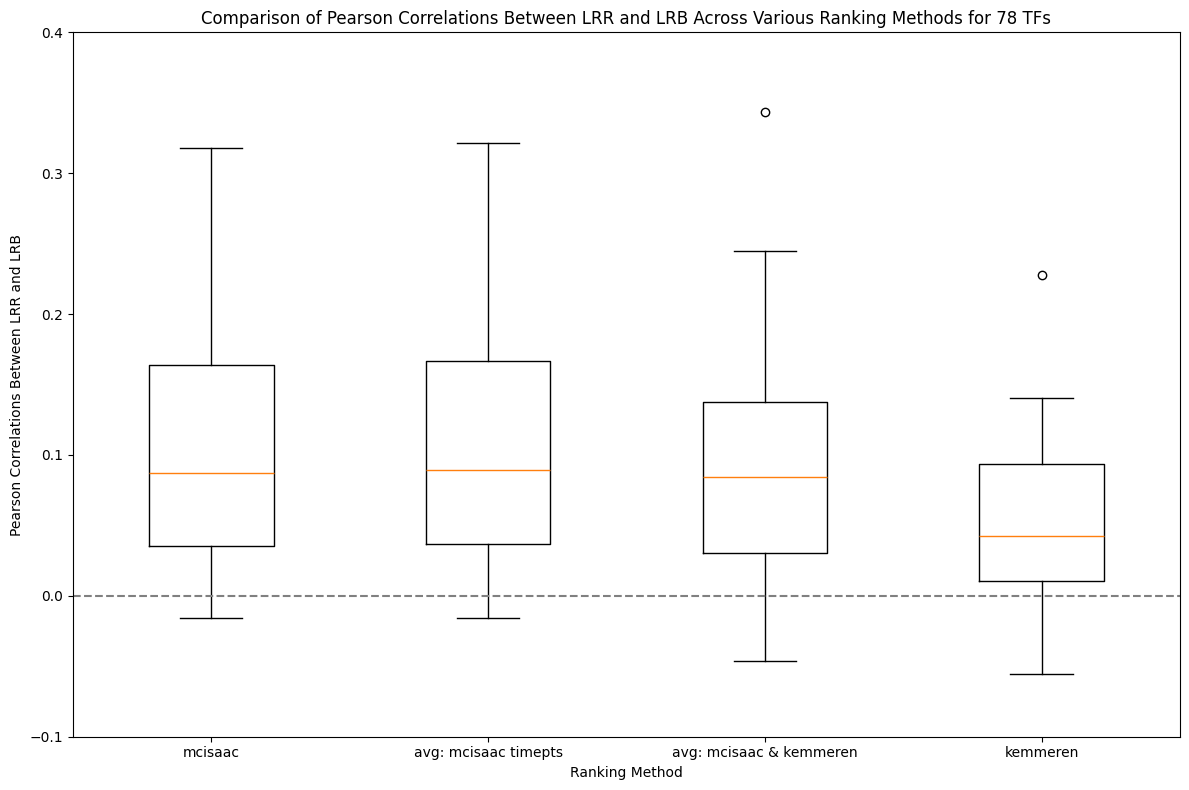

In [70]:
data = [cc_mcisaac_pearson_correlations['mcisaac'], cc_mcisaac_averagebymcisaac_pearson_correlations['mcisaac'], cc_mcisaac_averagemcisaackemmeren_pearson_correlations['mcisaac'], cc_kemmeren_pearson_correlations['kemmeren']]
binding_labels = ["cc+mitra", "harbison"]
perturbation_labels = ["mcisaac", "avg: mcisaac timepts", "avg: mcisaac & kemmeren","kemmeren"]
plot_combined_boxplot(data, perturbation_labels)

The plot above compares the boxplots of the Pearson correlations between the LRR and LRB across the various perturbation ranking approaches. On the x-axis, the label below the boxplot indicates the method in which the perturbation data was ranked to produce the final LRR/LRB correlation value. The y-axis then plots a partial scale of the Pearson correlation values from -0.1 to 0.4 as all of the data in the boxplots is confined to this region. Upon immediate observation, it is evident that using the normal ranking of the perturbation magnitude for the mcisaac 15 minute data (leftmost boxplot) yields a similar boxplot to that of averaging the ranks of the perturbation magnitudes across the 4 mcisaac timepoints (second to left boxplot). The other two boxplots suggest that the Pearson correlations generated according to those approaches tend to show weaker Pearson correlations as the overall boxplots are shifted vertically downwards suggusting a spread of correlations that are closer to 0. However, given that the boxplots of the normal perturbation ranking on the mcisaac 15 minute data is so similar to that of averaging the rankings across the 4 mcisaac timepoints, it suggests that taking the extra step to perform this average ranking is not enough to produce a noticeable improvement in the Pearson correlations. 

We can also plot the boxplots of the first and last binned mean differences from binning the data.

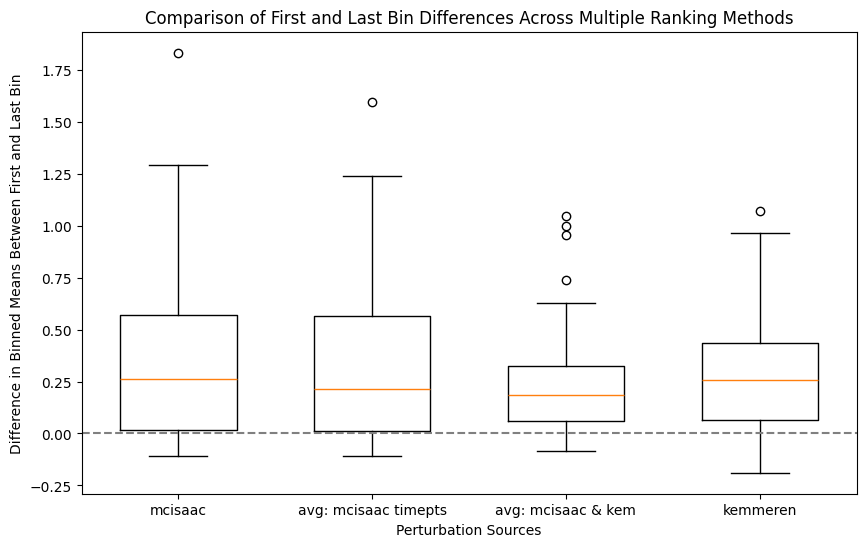

In [104]:
compare_first_and_last_stored_data_box_plots([cc_mcisaac_regular_first_last_data, cc_mcisaac_averagebymcisaactimes_first_last_data,cc_mcisaac_averagemcisaackemmeren_first_last_data, cc_kemmeren_regular_first_last_data], ['mcisaac','avg: mcisaac timepts', 'avg: mcisaac & kem', "kemmeren"])

Here, it appears that using the normal ranking of the perturbation effects on the mcisaac 15 minute data (leftmost boxplot) or the normal ranking of the perturbation effects on the kemmeren data (rightmost boxplot) surprisingly yield the best results. This is because we would expect the more complex ranking approaches to hopefully reduce ties in the perturbation data, leading to better rankings and clearer trends. Yet, these boxplots suggest that either using the normal mcisaac ranking, which produces a greater spread of data, or using the kemmeren normal ranking, which produces a smaller spread of data but has a lower minimum and maximum, could both be good options to rank the data. 

Overall, from these two boxplots, it appears that performing the extra steps to re-rank the data either by averaging ranks across various mcisaac timepoints or by averaging between the mcisaac and kemmeren perturbation data do not result in better trends in the data as evidenced by the boxplot comparisons. 

### **Which Approaches of Ranking the Binding Data Yields the Best Trends?**

On the binding side, it's worth further exploring the which ranking method is most optimal. We essentially have 3 options: using the enrichment values, poisson pvalues, or hypergeometric pvalues to rank the binding data by. We have currently been ranking the data according to the poisson pvalues, but given that multiple experiment outcomes can produce the same pvalue, resulting to many ties that may decrease the resolution of the trends we are graphing, it is worth considering if the other two ranking methods can produce higher average ranks that result in less ties, hopefully producing more observable trends. The boxplots below are generated by taking the highest rank by each of the three methods on each TF, and generating this data across the entire Calling Cards TF pool to determine which may produce the highest average ranks.

#### Code

In [412]:
async def fetch_binding_data_async(tf_name: str, is_aggregated: bool, pseudocount: int = 1) -> pd.DataFrame:
    """
    Fetch binding data for a transcription factor and compute the 'effect' size.
    
    :param tf_name: The name of the transcription factor.
    :type tf_name: str
    :param is_aggregated: Indicates whether the data is aggregated.
    :type is_aggregated: bool
    :param pseudocount: The constant used in calculating enrichment scores to avoid division by zero, default is 1.
    :type pseudocount: int
    
    :returns: A DataFrame containing the binding data with 'effect' computed.
    :rtype: pd.DataFrame
    """

    tf_name_upper = tf_name.upper()
    pss_api_tf = PromoterSetSigAPI()
    
    if is_aggregated:
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
    else:
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    id = tf_pss.get("metadata")["id"][0]
    binding_df = tf_pss.get("data").get(str(id))

    binding_data = binding_df
    binding_data.rename(columns={"callingcards_enrichment": "effect"}, inplace=True)
    binding_data['effect'] = (binding_data['experiment_hops'] / binding_data['experiment_total_hops']) / \
                             ((binding_data['background_hops'] + pseudocount) / binding_data['background_total_hops'])

    return binding_data

def fetch_binding_data(tf_name: str, is_aggregated: bool, pseudocount: int = 1) -> pd.DataFrame:
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(fetch_binding_data_async(tf_name, is_aggregated, pseudocount))

def assign_rankings(binding_data: pd.DataFrame) -> pd.DataFrame:
    """
    Assign rankings to the binding data based on 'effect', 'poisson_pvalue', and 'hypergeometric_pvalue'.
    
    :param binding_data: The binding data to rank.
    :type binding_data: pd.DataFrame
    
    :returns: A DataFrame with rankings assigned.
    :rtype: pd.DataFrame
    """
    binding_data['rank_effect'] = binding_data['effect'].rank(ascending=False, method='average')
    binding_data['rank_poisson'] = binding_data['poisson_pval'].rank(ascending=True, method='average')
    binding_data['rank_hypergeometric'] = binding_data['hypergeometric_pval'].rank(ascending=True, method='average')

    return binding_data

def find_smallest_ranks(binding_data: pd.DataFrame) -> pd.Series:
    """
    Find the smallest rank for each ranking method.
    
    :param binding_data: The binding data with rankings.
    :type binding_data: pd.DataFrame
    
    :returns: A Series containing the smallest ranks for each method.
    :rtype: pd.Series
    """
    smallest_ranks = {
        'rank_effect': binding_data['rank_effect'].min(),
        'rank_poisson': binding_data['rank_poisson'].min(),
        'rank_hypergeometric': binding_data['rank_hypergeometric'].min()
    }

    return pd.Series(smallest_ranks)

def compare_tf_rankings(tfs: list, bool_list: list, binding_source: str, pseudocount: int = 1):
    """
    Compare the smallest ranks across multiple transcription factors and generate boxplots.
    
    :param tfs: A list of transcription factor names.
    :type tfs: list
    :param is_aggregated: Indicates whether the data is aggregated.
    :type is_aggregated: bool
    :param pseudocount: The constant used in calculating enrichment scores to avoid division by zero, default is 1.
    :type pseudocount: int
    """
    all_ranks_effect = []
    all_ranks_poisson = []
    all_ranks_hypergeometric = []

    for i in range(len(tfs)):
        binding_data = fetch_binding_data(tfs[i], bool_list[i], pseudocount)
        ranked_data = assign_rankings(binding_data)
        smallest_ranks = find_smallest_ranks(ranked_data)
        
        all_ranks_effect.append(smallest_ranks['rank_effect'])
        all_ranks_poisson.append(smallest_ranks['rank_poisson'])
        all_ranks_hypergeometric.append(smallest_ranks['rank_hypergeometric'])

    # Generate boxplots
    plt.figure(figsize=(12, 8))
    plt.boxplot([all_ranks_effect, all_ranks_poisson, all_ranks_hypergeometric], labels=['Effect', 'Poisson p-value', 'Hypergeometric p-value'])
    plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal dotted line at y=0
    plt.xlabel('Ranking Method')
    plt.ylabel('Smallest Rank')
    plt.title(f'Comparison of Smallest Ranks Across TFs on {binding_source} data')
    plt.show()

Here we are plotting the original boxplots but ranking the binding data using the enrichment values instead of the poisson pvalues to see how the boxplots will change. First, we need to make a slight change to the process_dataframe method so that it ranks the enrichment scores instead of the pvalues

In [ ]:
def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes a DataFrame further by calculating ranks and log transformations for expression and binding data to elucidate certain trends.
    
    :param df: The input DataFrame containing 'effect_perturbation' and 'pvalue_binding' columns.
    :type df: pd.DataFrame
    
    :returns: A DataFrame that includes the original data along with new columns for expression ranks, log-transformed ranks, binding ranks, and is sorted by the negative log-transformed binding rank.
    :rtype: pd.DataFrame
    """
    # Calculate expression rank with average ties method
    df['expression_rank'] = rankdata(-abs(df['effect_perturbation']), method='average')

    # Log transform the expression rank
    df['neg_expression_rank_log'] = -np.log10(df['expression_rank'])

    # Calculate binding rank with average ties method
    df['binding_rank'] = rankdata(-df['effect_binding'], method='average')

    # Calculate log transform of the binding rank
    df['neg_log_rank_binding'] = -np.log10(rankdata(df['binding_rank'], method='average'))

    # Select specific columns
    plotting_df = df[['effect_perturbation', 'expression_rank', 'neg_expression_rank_log', 
                      'pvalue_binding', 'binding_rank', 'neg_log_rank_binding']]

    # Arrange (sort) by neg_log_rank_binding in descending order
    plotting_df = plotting_df.sort_values(by='neg_log_rank_binding', ascending=False)
    
    return plotting_df

#### Application

/var/folders/25/6s7q5c9j40373whzd3q5s20m0000gn/T/ipykernel_6092/2867473121.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_ranks_effect, all_ranks_poisson, all_ranks_hypergeometric], labels=['Effect', 'Poisson p-value', 'Hypergeometric p-value'])


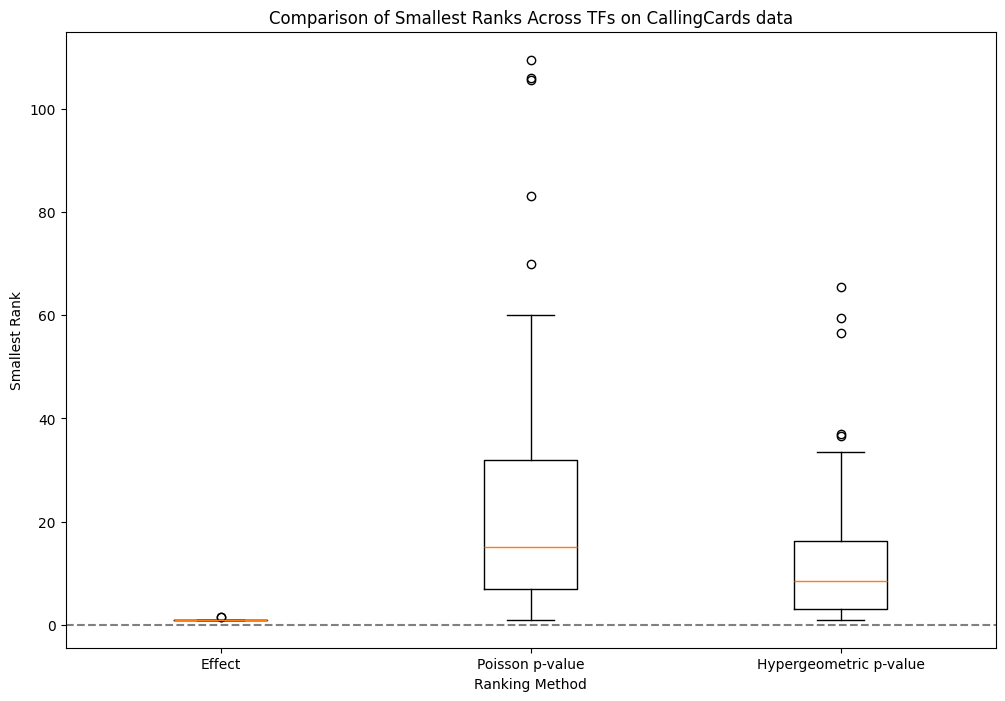

In [413]:
#Using this on CallingCards Data
tfs = ['WTM1', 'MIG2', 'CAT8', 'PDR1', 'PHO4', 'RIM101', 'GZF3', 'VHR1', 'ASH1', 'GAT3','FHL1', 'TEC1', 'SIP3', 'SKN7', 'WTM2','PHO2', 'HAA1', 'ADR1', 'MET31', 'CRZ1', 'RPH1', 'CHA4', 'CAD1', 'ZAP1', 'SKO1', 'ACA1', 'FZF1', 'HAP2', 'HAP3', 'HAP5','INO4', 'ERT1', 'TOG1', 'MET4', 'PPR1', 'RTG1', 'GLN3', 'MOT3', 'AFT1', 'GIS1', 'CBF1', 'SUM1', 'MSN2', 'DAL80', 'UPC2','RTG3', 'GAL80', 'RSF2', 'RME1', 'HIR2', 'SIP4', 'GCR1', 'HAP4', 'UME1', 'MET32', 'USV1', 'MGA1', 'CIN5', 'ROX1','XBP1', 'ZNF1', 'YHP1', 'RDR1', 'PDR3', 'RLM1', 'SFL1', 'SMP1', 'SUT2', 'HAC1', 'PHD1', 'ARO80']
#Assigning the correct boolean to each TF based on whether the TF contains aggregated data in the database or not
boolean_list = [True] * 59 + [False] * 12

compare_tf_rankings(tfs, boolean_list, "CallingCards")

This is quite interesting. Immediately, your attention might be drawn to the leftmost boxplot for the enrichment values. Since the y-axis is plotting the smallest rank across each TF, it appears that for the effect boxplot, almost the entire TF dataset produces a rank of 1 as the smallest rank. This means that there is a clear difference in enrichment values that reuslts in a higher rank as opposed to the other two pvalue methods, whose medians and lower quartiles hover closer to 10 than 0, suggesting greater ties at the top resulting in larger highest ranks. Seeing that using enrichment values to rank produces higher ranks in general, it is worth plotting the original data but using the negative log rank of the enrichment on the x-axis to see how the boxplots will differ. We do that now.

We can use our methods introduced above to compare the boxplots for the mcisaac data ranked using enrichment scores vs. perturbation scores.

In [377]:
tfs = ['WTM1','MIG2','CAT8','PDR1','PHO4','RIM101','GZF3','ASH1','GAT3','TEC1','SIP3','SKN7','WTM2','PHO2','HAA1','ADR1','MET31','CRZ1','RPH1','CHA4','CAD1','ZAP1','SKO1','ACA1','FZF1','HAP2','HAP3','HAP5','INO4','ERT1','TOG1','PPR1','RTG1','GLN3','MOT3','AFT1','CBF1','SUM1','MSN2','DAL80','UPC2','RTG3','GAL80','RSF2','RME1','HIR2','SIP4','HAP4','UME1','MET32','USV1','MGA1','CIN5','ROX1','XBP1','ZNF1','YHP1','RDR1','PDR3','RLM1','SFL1','SMP1','SUT2','HAC1','PHD1','ARO80']
boolean_list = [True]*54 + [False]*12
cc_mcisaac_adjacent_enrichment_data = adjacent_differences_store_data(tfs, boolean_list, "cc", perturbation_sources = ["mcisaac"], bins = 5)

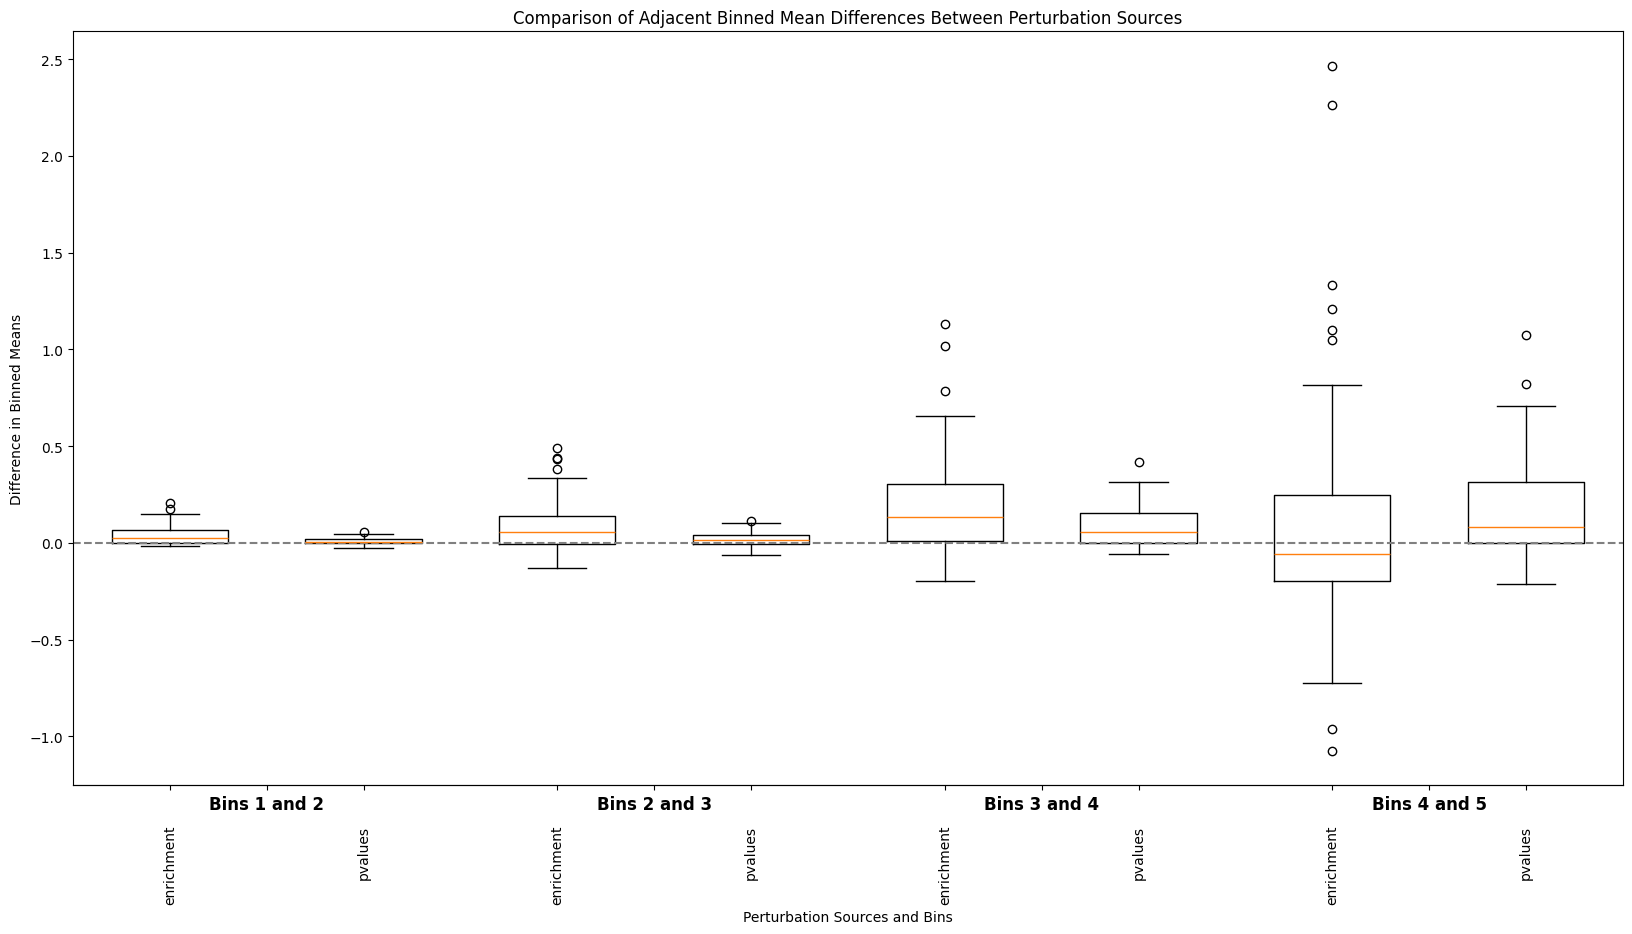

In [378]:
stored_data_list = [cc_mcisaac_adjacent_enrichment_data, cc_mcisaac_adjacent_data]
labels = ['enrichment', 'pvalues']
compare_adjacent_stored_data_box_plots(stored_data_list, labels)

This comparison is interesting for several reasons. First, the boxplots generated by ranking the data using enrichment values are considerably more spread out, suggesting greater variability using this method, While the medians for the first three adjacent bin differences using ranking by enrichment are slightly higher than ranking by poisson pvalues, the comparison of the rightbox boxplots shows that ranking by poisson pvalues is more optimal as the boxplot spread is mainly positive whereas the boxplot generating by ranking using enrichment has an overall neutral spread. Let us also look at how the first and last bin mean difference boxplots compare against one another.

In [379]:
cc_mcisaac_first_last_enrichment_data = first_last_bin_difference_box_plot_comparisons(tfs, boolean_list, "cc", perturbation_sources = ["mcisaac"], bins = 5)

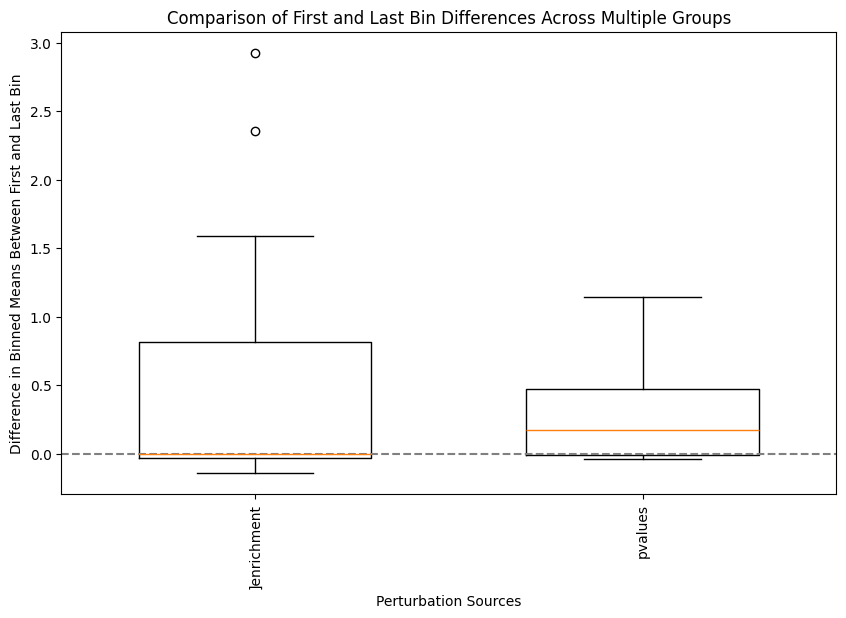

In [380]:
stored_data_list = [cc_mcisaac_first_last_enrichment_data, cc_mcisaac_first_last_data]
labels = [']enrichment', 'pvalues']
compare_first_and_last_stored_data_box_plots(stored_data_list, labels)

By ranking with poisson pvalues, we obtain a boxplot with both a smaller spread and a greater distribution of data that is above 0. Again, since the data in the lower quartile to the median is roughly 0 when ranking by enrichment, this is less optimal when compared to the boxplot ranking by poisson pvalues as more of the data generally exhibits a positive trend. Thus, we conclude continuing to plot by the poisson p values is likely the most optimal way to produce an observable trend for the eventual model to learn from.

We have shown above multiple comparisons between various binding and peturbation sources, as well as methods for ranking data. Now, we want to compile a comprehensive comparison of the first and last bin mean difference boxplots across the various binding and perturbation sources. We will use our regular method of ranking the perturbation data, and continue using the poisson pvalues when ranking the binding data. Having these boxplots together will give us the best visual comparison of how the combinations of data hold up against one another.

## **Creating Linear Models from the Data**

Lastly, we are interested in understanding how certain variables in the data are related to one another. Specifically, we are interested in 3 predictor variables and 1 outcome variable: 

1) gene_symbol (predictor): the gene at which a particular TF binds to
2) TF_symbol (predictor): the transcription factor itself
3) LRB (predictor): the negative log rank of the poisson pvalues for binding
4) LRR (outcome): the negative log rank of the perturbation effect magnitudes 

In order to understand how these predictors relate to the LRR, we need to build linear models that utilize combinations of these predictors to better understand how they correlate with the outcome. In order to do this, we will aggregate the data across the 78 TFs we have previously worked with to create a large dataframe that sorts the data first by the TF_symbol, then by the gene_symbol. The LRR ranking will be performed by first assigning a rank across all of the perturbation effect magnitudes in the entire dataframe, and then taking the negative log. Since we are assigning ranks across the entire aggregated dataframe, we call this a "global" ranking. For the LRB, we will rank the data in two ways. The first way will be performed similar to the LRR in which a global ranking across all of the binding poisson pvalues will be performed. However, we will also perform a separate ranking of the pvalues in which we will only assign ranks within a particular TF_symbol value, meaning that for a particular TF, we will rank the binding pvalues in the same way we have perviously, and then aggregate all of these LRB values. We call this method of ranking according to segmentations in the TF_symbol data a "local" ranking. Thus, we will obtain two separate dataframes. In both, the LRR will be ranked globally, while the LRB will be ranked globally for one and locally for the other. For this example, we will use data for the 78 TFs derived from the CC+mitra binding dataset and the mcisaac perturbation dataset.

Once we have obtained the data, we want to create the following linear models:

1) Single variable models to predict the LRR
2) A joint variable model to predict the LRR
3) Models in which the effects of gene_symbol, TF_symbol, or both are removed to determine how much of the remaining variance explained is acccounted for by the LRB

We will obtain the correlation coefficients of these models to better determine the strength of each predictor in assessing the outcome.

### **Obtaining Data for the Linear Models**
We will define a couple of modified functions that will process the data from the desired binding/perturbation source for our set of 78 TFs. 

#### Code

In [87]:
async def process_transcription_factor_async(tf_name: str, is_aggregated: bool, binding_source: str, perturbation_source: str, pseudocount: int = 1) -> pd.DataFrame:    
    """
    Process transcription factor data by retrieving and merging binding and perturbation datasets.
    
    :param tf_name: The name of the transcription factor, e.g., "AR080".
    :type tf_name: str
    :param is_aggregated: Indicates whether the data is aggregated.
    :type is_aggregated: bool
    :param binding_source: The source of the binding data, e.g., "cc" or "harbison".
    :type binding_source: str
    :param perturbation_source: The source of the perturbation data, e.g., "mcisaac".
    :type perturbation_source: str
    :param pseudocount: The constant used in calculating enrichment and p-values scores to avoid division by zero, default is 1.
    :type pseudocount: int, optional
    
    :returns: A DataFrame containing the combined and processed binding and perturbation data.
    :rtype: pd.DataFrame
    """
    # Ensure the TF name is in uppercase to maintain consistency
    tf_name_upper = tf_name.upper()
    
    # Initialize API for binding data
    pss_api_tf = PromoterSetSigAPI()

    # Access the relevant data depending on the binding source and aggregation status
    if binding_source == "cc":
        if is_aggregated:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "datasource": "brent_nf_cc", "aggregated": "true"})
        else:
            pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "workflow": "nf_core_callingcards_1_0_0", "data_usable": "pass"})
    elif binding_source == "harbison":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "4"})
    elif binding_source == "mitra":
        pss_api_tf.push_params({'regulator_symbol': tf_name_upper, "source": "2"})

    # Asynchronously read the binding data from the API
    tf_pss = await pss_api_tf.read(retrieve_files=True)
    # Get the ID of the retrieved binding data
    id = tf_pss.get("metadata")["id"][0]
    # Extract the binding data using the ID
    binding_df = tf_pss.get("data").get(str(id))

    # Initialize API for perturbation data
    expression = ExpressionAPI()

    # Map perturbation source to corresponding source number
    source_mapping = {
        "mcisaac": "7",
        "hu_reimann": "5",
        "kemmeren": "6"
    }
    source_number = source_mapping.get(perturbation_source, "unknown")
    
    # Push parameters to retrieve the perturbation data
    if perturbation_source == "mcisaac":
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number, "time": "15"})
    else:
        expression.push_params({"regulator_symbol": tf_name_upper, "source": source_number})

    # Asynchronously read the perturbation data from the API
    expression_res = await expression.read(retrieve_files=True)
    # Get the ID of the retrieved perturbation data
    id = expression_res.get("metadata")["id"][0]
    # Extract the perturbation data using the ID
    expression_df = expression_res.get("data").get(str(id))

    # Read perturbation data
    perturbation_data = expression_df
    # Read binding data
    binding_data = binding_df

    # Rename columns in binding data for consistency and clarity
    if binding_source == "cc":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)
    elif binding_source == "harbison":
        binding_data.rename(columns={"pval": "pvalue"}, inplace=True)
    elif binding_source == "mitra":
        binding_data.rename(columns={"callingcards_enrichment": "effect", "poisson_pval": "pvalue"}, inplace=True)

    # Optional: here you can modify the pseudocount as needed. The default pseudocount is set to 1.
    # Calculate the effect size for binding data using the provided formula
    if binding_source == "cc":
        binding_data['effect'] = (binding_data['experiment_hops'] / binding_data['experiment_total_hops']) / \
                             ((binding_data['background_hops'] + pseudocount) / binding_data['background_total_hops'])

    # Merge the binding data and perturbation data on the 'target_locus_tag' column
    combined_data = pd.merge(binding_data, perturbation_data, on='target_locus_tag', suffixes=('_binding', '_perturbation'))

    # # Assert that the length of combined_data is the minimum of the lengths of binding_data and perturbation_data
    # assert len(combined_data) <= min(len(binding_data), len(perturbation_data)), \
    #     f"Length of combined_data ({len(combined_data)}) is not equal to the minimum of lengths of binding_data ({len(binding_data)}) and perturbation_data ({len(perturbation_data)})"

    # Keep only the necessary columns in the combined data
    # combined_data = combined_data[['target_locus_tag', 'effect_binding', 'effect_perturbation', 'pvalue_binding']]

    # Reorder the combined data by the smallest 'pvalue_binding' values
    combined_data = combined_data.sort_values(by='pvalue_binding')

    # Apply transformations:
    # - Take the absolute value of 'effect_perturbation'
    # - Calculate the negative log10 of 'pvalue_binding'
    # - Calculate the log10 of 'effect_binding'
    combined_data['effect_perturbation'] = combined_data['effect_perturbation'].abs()
    combined_data['neg_log_pvalue_binding'] = -np.log10(combined_data['pvalue_binding'])
    combined_data['log_enrichment'] = np.log10(combined_data['effect_binding'])

    # Return the processed combined data as a DataFrame
    return combined_data

def aggregate_tf_data(tfs: List[str], boolean_list: List[bool], binding_source: List[str], perturbation_source:str) -> pd.DataFrame:
    """
    Aggregates data for a list of transcription factors by calling the
    process_transcription_factor method and combining the resulting DataFrames.
    
    :param tfs: A list of transcription factors.
    :type tfs: List[str]
    
    :returns: A DataFrame containing the aggregated data.
    :rtype: pd.DataFrame
    """
    aggregated_data = pd.DataFrame()  # Initialize an empty DataFrame
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        for i in range(len(tfs)):
            #print("current tf:" + str(tfs[i]))
            tf_data = process_transcription_factor(tfs[i],boolean_list[i], binding_source[i], perturbation_source)  # Process each TF to get its DataFrame
            aggregated_data = pd.concat([aggregated_data, tf_data], ignore_index=True)  # Aggregate the DataFrame

    return aggregated_data

def resort_and_rank_dataframe(df: pd.DataFrame, method: str) -> pd.DataFrame:
    """
    Resorts the dataframe by 'target_symbol' and 'regulator_symbol', then calculates
    the ranks for 'effect_binding' and 'effect_perturbation' columns using a global ranking, and filters the
    dataframe to include only the specified columns.
    
    :param df: The raw dataframe to be processed.
    :type df: pd.DataFrame
    
    :returns: The processed dataframe with sorted and ranked columns.
    :rtype: pd.DataFrame
    """
    # Sort by 'target_symbol' and then by 'regulator_symbol'
    df = df.sort_values(by=['regulator_symbol_perturbation','target_symbol_perturbation'])

    df['expression_rank'] = rankdata(-abs(df['effect_perturbation']), method='average')
    
    # Log transform the expression rank
    df['LRR'] = -np.log10(df['expression_rank'])

    if method == "global":
        # Calculate binding rank globally
        df['binding_rank'] = rankdata(-abs(df['pvalue_binding']), method='average')

    elif method == "local":
        # Calculate binding rank locally within each TF
        df['binding_rank'] = df.groupby('regulator_symbol_perturbation')['pvalue_binding'].transform(lambda x: rankdata(-abs(x), method='average'))
    # Calculate log transform of the binding rank
    df['LRB'] = -np.log10(df['binding_rank'])

    df.rename(columns={
    'target_symbol_perturbation': 'gene_symbol',
    'regulator_symbol_perturbation': 'TF_symbol',
    }, inplace=True)

    # Filter the dataframe to include only the specified columns
    df_filtered = df[['TF_symbol', 'gene_symbol','LRB', 'LRR']]
    
    return df_filtered

In [ ]:
raw_combined_cc_mcisaac_data = aggregate_tf_data(all_tfs, boolean_list, cc_to_mitra_ratio_in_all, "mcisaac")
#tfs = ['WTM1','MIG2','CAT8','PDR1','PHO4','RIM101','GZF3','ASH1','GAT3','TEC1','SIP3','SKN7','WTM2','PHO2','HAA1','ADR1','MET31','CRZ1','RPH1','CHA4','CAD1','ZAP1','SKO1','ACA1','FZF1','HAP2','HAP3','HAP5','INO4','ERT1','TOG1','PPR1','RTG1','GLN3','MOT3','AFT1','CBF1','SUM1','MSN2','DAL80','UPC2','RTG3','GAL80','RSF2','RME1','HIR2','SIP4','HAP4','UME1','MET32','USV1','MGA1','CIN5','ROX1','XBP1','ZNF1','YHP1','RDR1','PDR3','RLM1','SFL1','SMP1','SUT2','HAC1','PHD1','ARO80']

filtered_cc_msisaac_data_global = resort_and_rank_dataframe(raw_combined_cc_mcisaac_data)
filtered_cc_msisaac_data_local = resort_and_rank_dataframe(raw_combined_cc_mcisaac_data)

filtered_cc_msisaac_data_global.head()

In [91]:
raw_combined_cc_mcisaac_data = aggregate_tf_data(["MIG2"], boolean_list, cc_to_mitra_ratio_in_all, "mcisaac")

filtered_cc_msisaac_data_local_MIG2 = resort_and_rank_dataframe(raw_combined_cc_mcisaac_data, "local")

filtered_cc_msisaac_data_local_MIG2.head()

,TF_symbol,gene_symbol,LRB,LRR
1325,MIG2,AAC1,-3.683362,-2.193125
1131,MIG2,AAC3,-3.700141,-3.502291
3546,MIG2,AAD10,-3.398808,-3.502291
2369,MIG2,AAD14,-3.574263,-3.502291
5240,MIG2,AAD15,-2.982271,-3.502291


Creating the model for formula: LRR ~ TF_symbol
Summary for model LRR ~ TF_symbol:
                            OLS Regression Results                            
Dep. Variable:                    LRR   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 13 Aug 2024   Prob (F-statistic):                nan
Time:                        13:13:01   Log-Likelihood:                -1328.4
No. Observations:                6151   AIC:                             2659.
Df Residuals:                    6150   BIC:                             2666.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

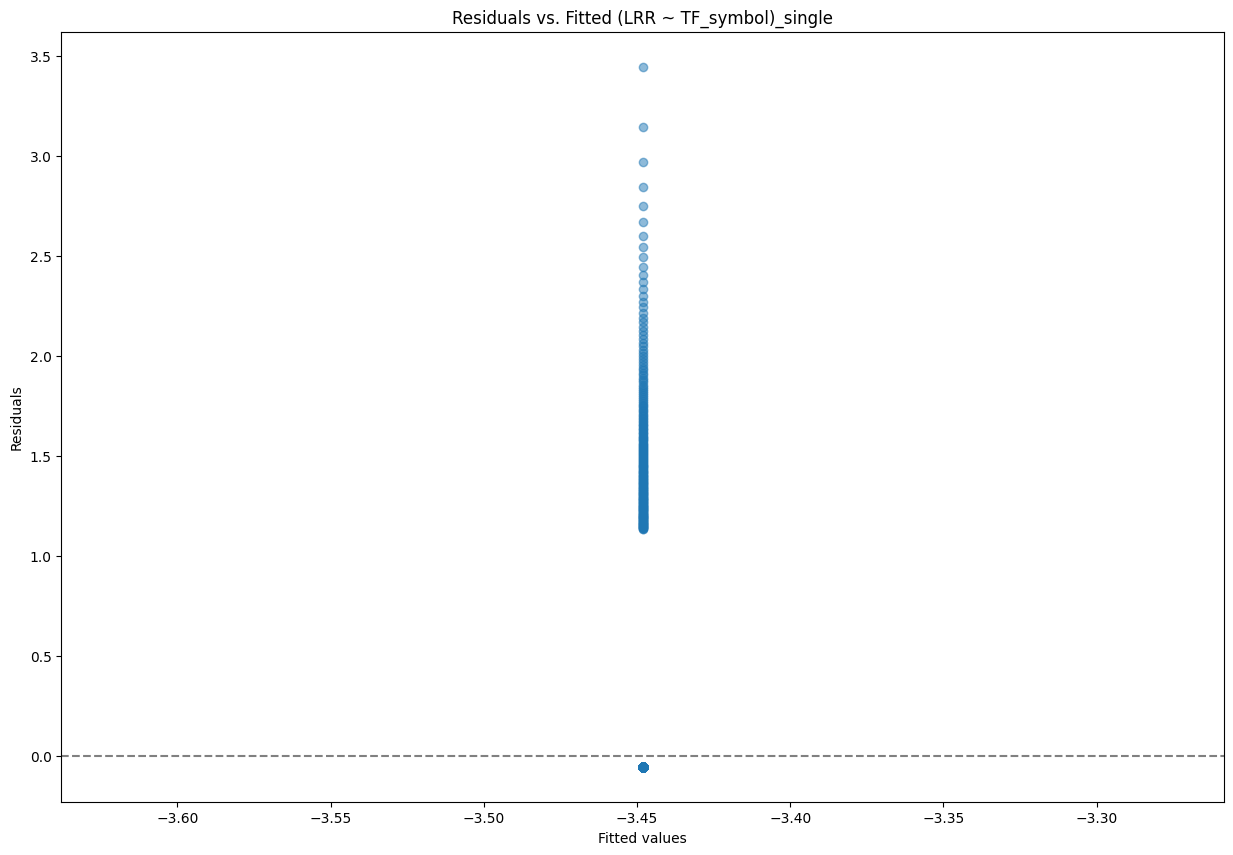

Creating the model for formula: LRR ~ LRB
Summary for model LRR ~ LRB:
                            OLS Regression Results                            
Dep. Variable:                    LRR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6444
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.422
Time:                        13:13:02   Log-Likelihood:                -1328.1
No. Observations:                6151   AIC:                             2660.
Df Residuals:                    6149   BIC:                             2674.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

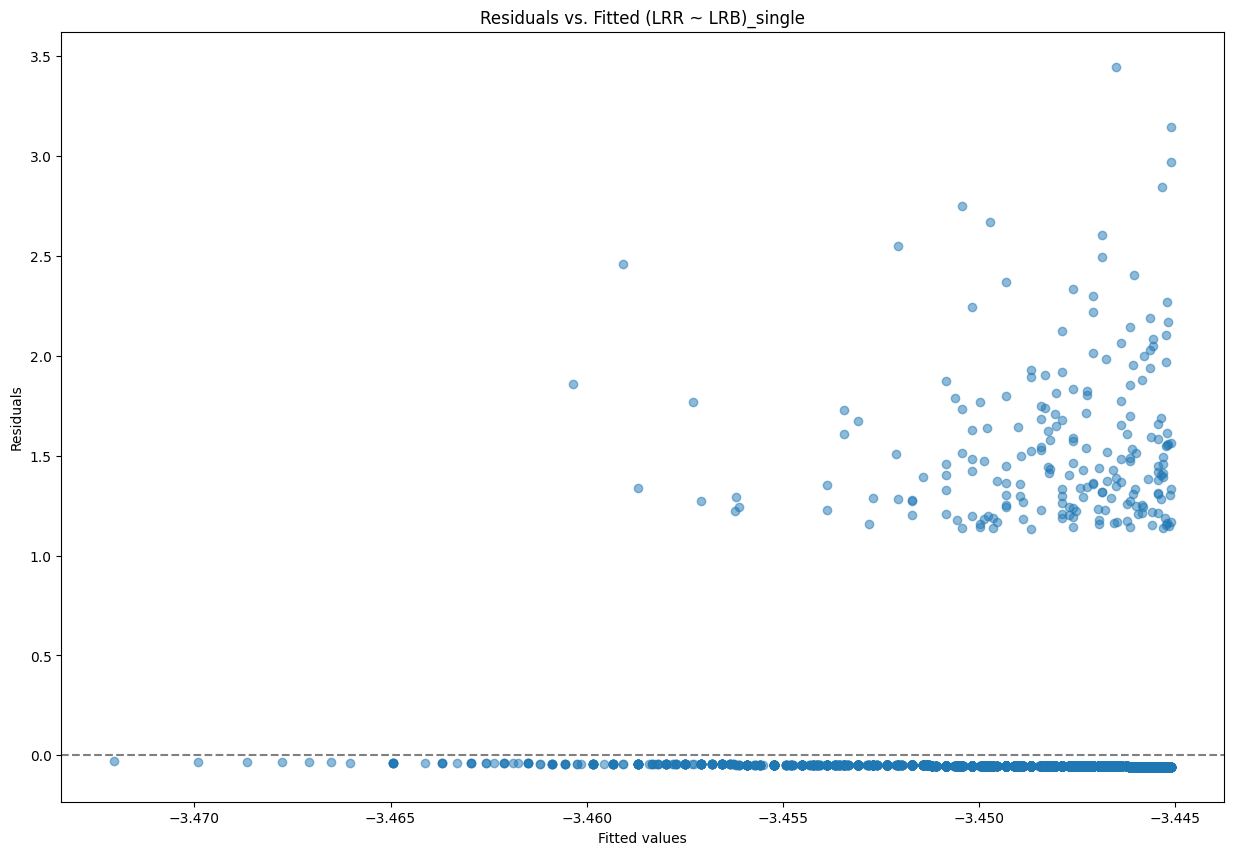

In [92]:


def run_linear_model(formula, data):
    print(f"Creating the model for formula: {formula}")
    y, X = patsy.dmatrices(formula, data=data)
    model = sm.OLS(y, X)
    fit_model = model.fit()

    # Print the summary of the model
    print(f"Summary for model {formula}:\n{fit_model.summary()}\n")

    return fit_model


def calculate_residuals(formula, data):
    print(f"Calculating residuals for formula: {formula}")
    y, X = patsy.dmatrices(formula, data=data)
    model = sm.OLS(y, X)
    fit_model = model.fit()
    residuals = fit_model.resid
    return residuals


def run_residual_model(residuals, independent_var, data, input_filename):
    print(f"Running model with residuals against {independent_var}")
    data = data.assign(residuals=residuals)  # Add residuals to the data frame
    formula = f"residuals ~ {independent_var}"
    fit_model = run_linear_model(formula, data)
    plot_diagnostics(
        fit_model, f"residuals_vs_{independent_var}_residual", input_filename
    )


def plot_diagnostics(fit_model, title_suffix, input_filename):
    # Extract the base name of the input file without extension
    input_basename = os.path.splitext(os.path.basename(input_filename))[0]

    # Extract fitted values and residuals
    fitted_values = fit_model.fittedvalues
    residuals = fit_model.resid
    standardized_residuals = residuals / np.std(residuals)

    # Plot 1: Residuals vs. Fitted
    plt.figure(figsize=(15, 10))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Fitted " + title_suffix)
    plt.show()

formulas = ["LRR ~ TF_symbol", "LRR ~ LRB"]
for formula in formulas:
    fit_model = run_linear_model(formula, filtered_cc_msisaac_data_local_MIG2)
    plot_diagnostics(fit_model, f"({formula})_single", "filtered_cc_msisaac_data_local_MIG2")

#### Application

This is an example of how the dataframe looks based on the description above. The data is organized first by the TF_symbol, then by the gene_symbol. For this dataframe, we performed a global ranking to obtain the LRB values.

In [ ]:
#save the data locally
filtered_cc_msisaac_data_global.to_csv("~/Downloads/filtered_cc_msisaac_data_global.csv", index = False)
filtered_cc_msisaac_data_local.to_csv("~/Downloads/filtered_cc_msisaac_data_local.csv", index = False)

### **Commands and Scripts for Running the Linear Models in HTCF Cluster**
Given the size of the data, running these models within this notebook isn't optimal. We used the HTCF cluster to run the scripts below. Note that running the scripts using the cluster requires the installation of singularity; you can find more information on how to use and install singularity using spack on the cluster here: https://htcf.wustl.edu/docs/software/ 
Below are the files used to run the three models.

#### Code for Files

In [ ]:
#code for the single variable models in the first objective
import argparse
import statsmodels.api as sm
import pandas as pd
import patsy


def run_linear_model(formula, data):
    print(f"Creating the model for formula: {formula}")
    y, X = patsy.dmatrices(formula, data=data)

    print("Fitting the model...")
    model = sm.OLS(y, X)
    fit_model = model.fit()

    # Print the formula used
    print(f"Running model with formula: {formula}")

    # Return the summary
    return fit_model.summary()


def main():
    parser = argparse.ArgumentParser(
        description="Run linear regression models from a CSV file."
    )
    parser.add_argument("--input", help="Path to the input CSV file.", required=True)

    args = parser.parse_args()

    # Load the data from the CSV file
    data = pd.read_csv(args.input)
    print(f"Data loaded from {args.input}")

    # Define formulas for the different models
    formulas = ["LRR ~ gene_symbol", "LRR ~ TF_symbol", "LRR ~ LRB"]

    # Run and print summary for each model
    for formula in formulas:
        print(f"Running model: {formula}")
        summary = run_linear_model(formula, data)
        print(f"Summary:\n{summary}\n")


if __name__ == "__main__":
    main()

In [ ]:
#code for the joint model in the second objective
import argparse
import statsmodels.api as sm
import pandas as pd
import patsy


def run_joint_linear_model(formula, data):
    print(f"Creating the joint model for formula: {formula}")
    y, X = patsy.dmatrices(formula, data=data)

    print("Fitting the joint model...")
    model = sm.OLS(y, X)
    fit_model = model.fit()

    # Print the formula used
    print(f"Running joint model with formula: {formula}")

    # Return the summary
    return fit_model.summary()


def main():
    parser = argparse.ArgumentParser(
        description="Run a joint linear regression model from a CSV file."
    )
    parser.add_argument("--input", help="Path to the input CSV file.", required=True)

    args = parser.parse_args()

    # Load the data from the CSV file
    data = pd.read_csv(args.input)
    print(f"Data loaded from {args.input}")

    # Define the formula for the joint model
    joint_formula = "LRR ~ gene_symbol + TF_symbol + LRB"

    # Run and print summary for the joint model
    print(f"Running joint model: {joint_formula}")
    summary = run_joint_linear_model(joint_formula, data)
    print(f"Summary of the joint model:\n{summary}\n")


if __name__ == "__main__":
    main()


In [ ]:
#code for the linear models in the third objective
import argparse
import statsmodels.api as sm
import pandas as pd
import patsy


def calculate_residuals(formula, data):
    print(f"Fitting model to calculate residuals for formula: {formula}")
    y, X = patsy.dmatrices(formula, data=data)
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    return residuals


def run_residual_model(residuals, independent_var, data):
    # Incorporating the residuals into the data used for regression
    data["residuals"] = residuals
    formula = f"residuals ~ {independent_var}"
    print(f"Creating model for residuals with formula: {formula}")
    y, X = patsy.dmatrices(formula, data=data)
    model = sm.OLS(y, X).fit()
    return model.summary()


def main():
    parser = argparse.ArgumentParser(
        description="Run regression models on residuals from a CSV file."
    )
    parser.add_argument("--input", help="Path to the input CSV file.", required=True)

    args = parser.parse_args()

    # Load the data from the CSV file
    data = pd.read_csv(args.input)
    print(f"Data loaded from {args.input}")

    # Calculate residuals for different combinations
    residuals_full = calculate_residuals("LRR ~ TF_symbol + gene_symbol", data)
    residuals_gene = calculate_residuals("LRR ~ gene_symbol", data)
    residuals_tf = calculate_residuals("LRR ~ TF_symbol", data)

    # Model residuals against LRB
    print("Modeling residuals from LRR ~ TF_symbol + gene_symbol")
    summary_full = run_residual_model(residuals_full, "LRB", data)
    print(summary_full)

    print("Modeling residuals from LRR ~ gene_symbol")
    summary_gene = run_residual_model(residuals_gene, "LRB", data)
    print(summary_gene)

    print("Modeling residuals from LRR ~ tf_symbol")
    summary_tf = run_residual_model(residuals_tf, "LRB", data)
    print(summary_tf)


if __name__ == "__main__":
    main()


#### Application

Here is an example of how to run the scripts after everything has been initialized into the cluster and ready to go.

interactive

eval $(spack load --sh singularityce)

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 single_variable_models.py --input data/filtered_cc_mcisaac_data_global.csv" - this has job id 17145975

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 single_variable_models.py --input data/filtered_cc_mcisaac_data_local.csv" - this has job id 17145977

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 joint_model.py --input data/filtered_cc_mcisaac_data_global.csv" - this has job id 17145979

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 joint_model.py --input data/filtered_cc_mcisaac_data_local.csv" - this has job id 17145980

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 residual_models.py --input data/filtered_cc_mcisaac_data_global.csv" - 17146057

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 residual_models.py --input data/filtered_cc_mcisaac_data_local.csv" - 17146058

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 single_variable_models.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_local.csv" - 17151563

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 joint_model.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_local.csv"  - 17151564

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 residual_models.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_local.csv"  - 17151565

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 single_variable_models.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_global.csv" - 17151566

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 joint_model.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_global.csv" - 17151567

sbatch --mem=100G ../scripts/singularity_exec.sh statsmodel.sif "python3 residual_models.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_global.csv" - 17151568


LRR Global LRB Global
sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_mcisaac_data_LRR_global_LRB_global.csv --mode 'single'" - 17162198

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_mcisaac_data_LRR_global_LRB_global.csv --mode 'joint'" - 17162199

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_mcisaac_data_LRR_global_LRB_global.csv --mode 'residual'" - 17162200

LRR Local LRB Global
sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_global.csv --mode 'single'" - 17162204

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_global.csv --mode 'joint'" - 17162205

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_global.csv --mode 'residual'" - 17162206

LRR Global LRB Local

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_mcisaac_data_LRR_global_LRB_local.csv --mode 'single'"  - 17162207

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_mcisaac_data_LRR_global_LRB_local.csv --mode 'joint'" - 17162208

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_mcisaac_data_LRR_global_LRB_local.csv --mode 'residual'" - 17162209

LRR Local LRB Local

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_local.csv --mode 'single'" - 17162215

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_local.csv --mode 'joint'" - 17162216

sbatch --mem=400G ../scripts/singularity_exec.sh statsmodel_plus.sif "python3 diagnostic_plots_new.py --input data/filtered_cc_msisaac_data_LRR_local_LRB_local.csv --mode 'residual'" - 17162217

You should save the batch job number or reference the progress of your scripts using the following commands:

check the status of how long your job has been running for:
squeue -u $USER

check the output of your job during/after it has finished running:
cat slurm-{BATCH_JOB_NUMBER}.out

### **Table of Results for the Linear Models**
The two tables below outline the results obtained after successful execution of the scripts based on whether the binding data was ranked globally or locally. The first 3 rows in each table represent the single variable models described in the first objective. The next row represents the joint model described in the second objective, and the last 3 rows are the models described in the third objective.

**LRR Global LRB Global**

| Model Formula | R^2 |
|----------|----------|
| LRR ~ gene_symbol | 0.040 |
| LRR ~ TF_symbol | 0.100 |
| LRR ~ LRB | 0.002 |
| LRR ~ gene_symbol + TF_symbol + LRB | 0.142 |
| resid(LRR~gene_symbol) ~ LRB | 0.002 |
| resid(LRR~TF_symbol) ~ LRB | 0.001 |
| resid(LRR~gene_symbol + TF_symbol) ~ LRB | 0.001 |

**LRR Global LRB Local**

| Model Formula | R^2 |
|----------|----------|
| LRR ~ gene_symbol | 0.040 |
| LRR ~ TF_symbol | 0.100 |
| LRR ~ LRB | 0.001 |
| LRR ~ gene_symbol + TF_symbol + LRB | 0.142 |
| resid(LRR~gene_symbol) ~ LRB | 0.001 |
| resid(LRR~TF_symbol) ~ LRB | 0.001 |
| resid(LRR~gene_symbol + TF_symbol) ~ LRB | 0.001 |

**LLR Local LRB Local**

| Model Formula | R^2 |
|----------|----------|
| LRR ~ gene_symbol | 0.048 |
| LRR ~ TF_symbol | 0.010 |
| LRR ~ LRB | 0.001 |
| LRR ~ gene_symbol + TF_symbol + LRB | 0.059 |
| resid(LRR~gene_symbol) ~ LRB | 0.001 |
| resid(LRR~TF_symbol) ~ LRB | 0.001 |
| resid(LRR~gene_symbol + TF_symbol) ~ LRB | 0.001 |

**LRR Local LRB Global**

| Model Formula | R^2 |
|----------|----------|
| LRR ~ gene_symbol | 0.048 |
| LRR ~ TF_symbol | 0.010 |
| LRR ~ LRB | 0.002 |
| LRR ~ gene_symbol + TF_symbol + LRB | 0.060 |
| resid(LRR~gene_symbol) ~ LRB | 0.001 |
| resid(LRR~TF_symbol) ~ LRB | 0.001 |
| resid(LRR~gene_symbol + TF_symbol) ~ LRB | 0.001 |

When comparing both tables, there are only minor differences in the values for some of the linear models. This means that changing the way that the LRB is ranked (i.e. locally or globally) is ultimately rather insignificant because the LRB itself is a poor predictor of the LRR as evidenced by the low correlation coefficients in the single variable model. This also means that even after removing the effects of the other two variables, the LRB is still does not do well in accounting for the remaining explained variance based on the low correlations obtained in the last 3 rows of data. On the other hand, the TF_symbol seems to be the best predictor of the outcome as it acheives the highest correlation, which the gene_symbol has a correlation that is below half that of the TF_symbol. Interestingly, this may imply that the identify of the transcription factor itself may lend a better hand at explaining the magnitude of perturbation effects when interacting with a particular gene, as opposed to the LRB or the identity of the gene interacting with the TF.  